# Introduction

This notebook embarks on an analysis of two distinct datasets, both sourced from experimental data. The initial dataset pertains to a Single Zone Constant Air Volume (SZCAV) Air Handling Unit (AHU), while the second dataset concerns a Single Zone Variable Air Volume (SZVAV) AHU.

Following data was used in the dataset:

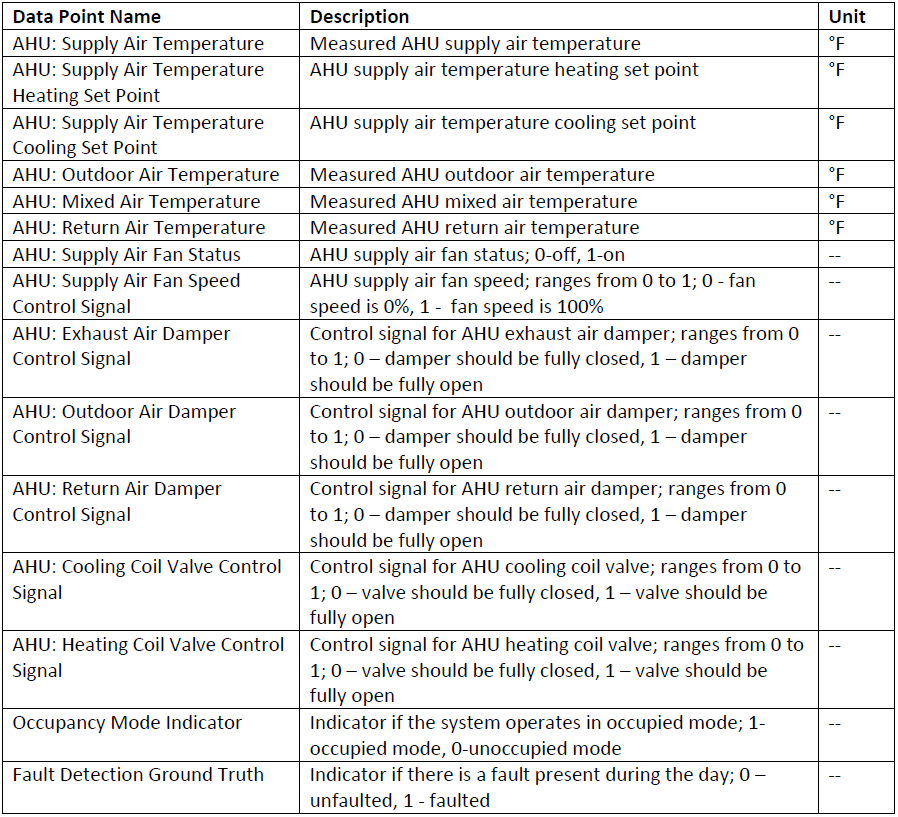

The faults within the dataset were introduced through experimental interventions. Each individual fault was intentionally imposed on the unit at midnight and persisted for the duration of an entire day. 

Fault imposed in single-zone constant air volume AHU are as follow:

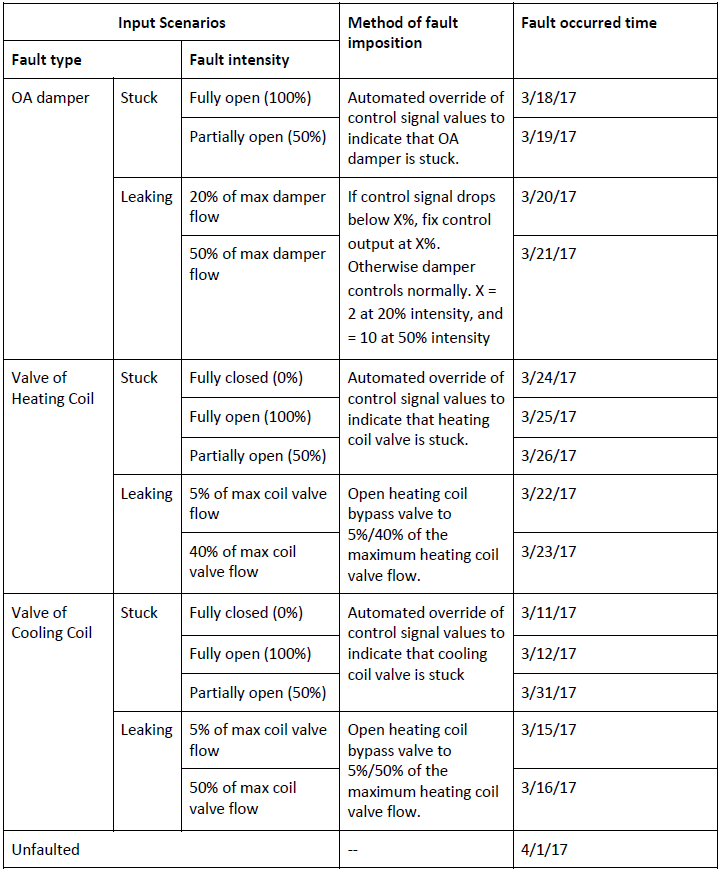

Fault imposed in single-zone variable air volume AHU are as follow:

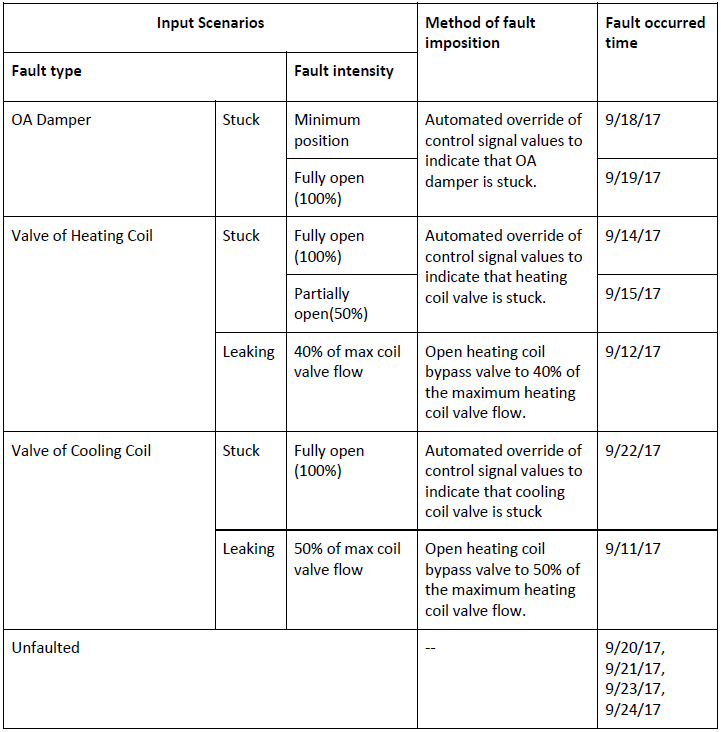

# Import of the relevant libraries and notebook preparation

In [68]:
import sys
import os

In [69]:
src_path = os.path.join(os.getcwd(), "..", "src")
sys.path.append(src_path)

In [70]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
from sklearn.model_selection import train_test_split
import warnings
from helper_functions import convert_date, train_evaluate_classification_models, train_evaluate_regression_models

In [71]:
from catboost import CatBoostClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.ensemble import GradientBoostingClassifier,AdaBoostClassifier,BaggingClassifier, RandomForestClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.linear_model import LogisticRegression
from xgboost import XGBClassifier

In [72]:
warnings.filterwarnings("ignore")

In [73]:
# preparing list of classifiacation algorithms for comparison and to choose the best one
classifiers = [['KNeighborsClassifier', KNeighborsClassifier()],
              ['MLPClassifier',MLPClassifier()],
              ['AdaBoostClassifier',AdaBoostClassifier()],
              ['GradientBoostingClassifier',GradientBoostingClassifier()],
              ['CatBoostClassifier', CatBoostClassifier()],
              ['XGBClassifier', XGBClassifier()],
              ['BaggingClassifier', BaggingClassifier()],
              ['RandomForestClassifier', RandomForestClassifier()],
              ['DecisionTreeClassifier', DecisionTreeClassifier()],
              ['LogisticRegression', LogisticRegression()]]

In [74]:
csv_file_path_1 = os.path.join("..", "data", "SZVAV.csv")
csv_file_path_2 = os.path.join("..", "data", "SZCAV.csv")

In [75]:
raw_data_vav = pd.read_csv(csv_file_path_1)

In [76]:
raw_data_cav = pd.read_csv(csv_file_path_2)

# Single-zone constant air volume AHU

## Data exploration and feature engineering

In [77]:
raw_data_cav.sample(5)

,Datetime,AHU: Supply Air Temperature,AHU: Supply Air Temperature Heating Set Point,AHU: Supply Air Temperature Cooling Set Point,AHU: Outdoor Air Temperature,AHU: Mixed Air Temperature,AHU: Return Air Temperature,AHU: Supply Air Fan Status,AHU: Supply Air Fan Speed Control Signal,AHU: Outdoor Air Damper Control Signal,AHU: Return Air Damper Control Signal,AHU: Exhaust Air Damper Control Signal,AHU: Cooling Coil Valve Control Signal,AHU: Heating Coil Valve Control Signal,Occupancy Mode Indicator,Fault Detection Ground Truth
11160,3/21/2017 18:00,66.96,50.00,86.0,56.25,65.93,68.78,1,0.5,0.00,1.0,0.0,0.0,0.000000,0,1
19014,3/31/2017 4:54,56.21,63.37,86.0,49.32,62.79,62.65,1,0.5,0.00,1.0,0.0,0.0,0.271443,0,1
19655,3/31/2017 15:35,58.43,59.96,86.0,68.98,66.34,65.09,1,0.5,0.15,1.0,0.0,0.0,0.000000,1,1
2748,3/12/2017 21:48,60.06,59.74,86.0,62.74,62.41,62.62,1,0.5,0.00,1.0,0.0,0.0,0.294991,0,1
9565,3/20/2017 15:25,69.75,70.18,86.0,56.68,66.65,69.94,1,0.5,0.15,1.0,0.0,0.0,0.303359,1,1


In [78]:
raw_data_cav.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 21600 entries, 0 to 21599
Data columns (total 16 columns):
 #   Column                                         Non-Null Count  Dtype  
---  ------                                         --------------  -----  
 0   Datetime                                       21600 non-null  object 
 1   AHU: Supply Air Temperature                    21600 non-null  float64
 2   AHU: Supply Air Temperature Heating Set Point  21600 non-null  float64
 3   AHU: Supply Air Temperature Cooling Set Point  21600 non-null  float64
 4   AHU: Outdoor Air Temperature                   21600 non-null  float64
 5   AHU: Mixed Air Temperature                     21600 non-null  object 
 6   AHU: Return Air Temperature                    21600 non-null  float64
 7   AHU: Supply Air Fan Status                     21600 non-null  int64  
 8   AHU: Supply Air Fan Speed Control Signal       21600 non-null  float64
 9   AHU: Outdoor Air Damper Control Signal         216

The dataset exhibits the absence of any null values, demonstrating its initial data integrity. However, adjustments are required in two columns: "AHU: Mixed Air Temperature" and "Datetime." Specifically, changes in datatype are necessary for these columns to ensure uniformity and proper handling of the data.

In [79]:
raw_data_cav['Datetime'] = pd.to_datetime(raw_data_cav['Datetime'])

In [80]:
# Changing column values to numeric values, changing all defective data to NaN
raw_data_cav['AHU: Mixed Air Temperature'] = pd.to_numeric(raw_data_cav['AHU: Mixed Air Temperature'],errors='coerce')

In [81]:
raw_data_cav['AHU: Mixed Air Temperature'].isna().sum()

90

It is observed that there are 90 rows within the "AHU: Mixed Air Temperature" column containing defective data. Given the dataset's scale, this represents a relatively minor fraction. Consequently, it is a reasonable approach to remove these rows, ensuring the overall dataset's integrity and consistency.

In [82]:
raw_data_cav.dropna(inplace=True)

In [83]:
raw_data_cav.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 21510 entries, 0 to 21599
Data columns (total 16 columns):
 #   Column                                         Non-Null Count  Dtype         
---  ------                                         --------------  -----         
 0   Datetime                                       21510 non-null  datetime64[ns]
 1   AHU: Supply Air Temperature                    21510 non-null  float64       
 2   AHU: Supply Air Temperature Heating Set Point  21510 non-null  float64       
 3   AHU: Supply Air Temperature Cooling Set Point  21510 non-null  float64       
 4   AHU: Outdoor Air Temperature                   21510 non-null  float64       
 5   AHU: Mixed Air Temperature                     21510 non-null  float64       
 6   AHU: Return Air Temperature                    21510 non-null  float64       
 7   AHU: Supply Air Fan Status                     21510 non-null  int64         
 8   AHU: Supply Air Fan Speed Control Signal       21510 non

In [84]:
# Preparing datasets for Boxplot visualisation
temp_col = [col for col in raw_data_cav.columns if "Temp" in col]
control_col = [col for col in raw_data_cav.columns if "Control" in col]
temp_data = raw_data_cav[temp_col].melt(var_name='Temperature column', value_name='Temperature in Fahrenheit')
control_data = raw_data_cav[control_col].melt(var_name='Control value column', value_name='0-1')

[Text(0, 0, 'AHU: Supply Air Temperature'),
 Text(1, 0, 'AHU: Supply Air Temperature Heating Set Point'),
 Text(2, 0, 'AHU: Supply Air Temperature Cooling Set Point'),
 Text(3, 0, 'AHU: Outdoor Air Temperature'),
 Text(4, 0, 'AHU: Mixed Air Temperature'),
 Text(5, 0, 'AHU: Return Air Temperature')]

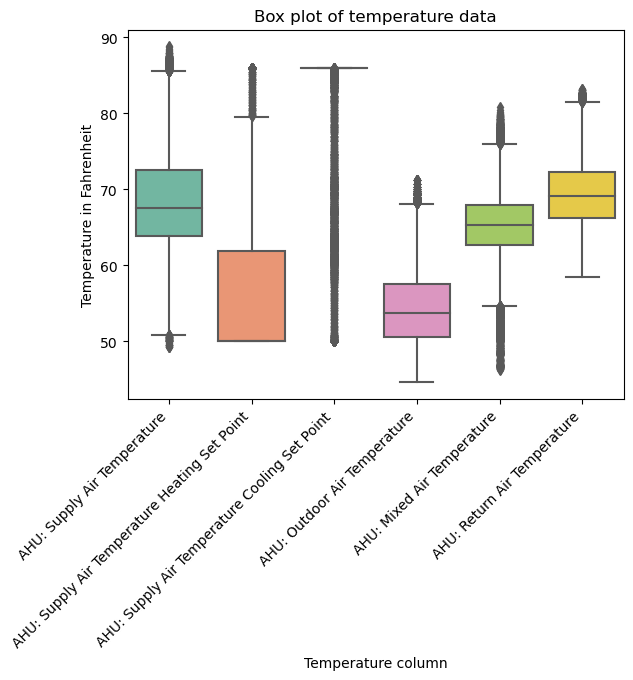

In [85]:
ax = sns.boxplot(x='Temperature column', y='Temperature in Fahrenheit', data=temp_data, palette="Set2")
plt.title("Box plot of temperature data")
ax.set_xticklabels(ax.get_xticklabels(), rotation=45, horizontalalignment='right')

[Text(0, 0, 'AHU: Supply Air Fan Speed Control Signal'),
 Text(1, 0, 'AHU: Outdoor Air Damper Control Signal  '),
 Text(2, 0, 'AHU: Return Air Damper Control Signal'),
 Text(3, 0, 'AHU: Exhaust Air Damper Control Signal    '),
 Text(4, 0, 'AHU: Cooling Coil Valve Control Signal'),
 Text(5, 0, 'AHU: Heating Coil Valve Control Signal')]

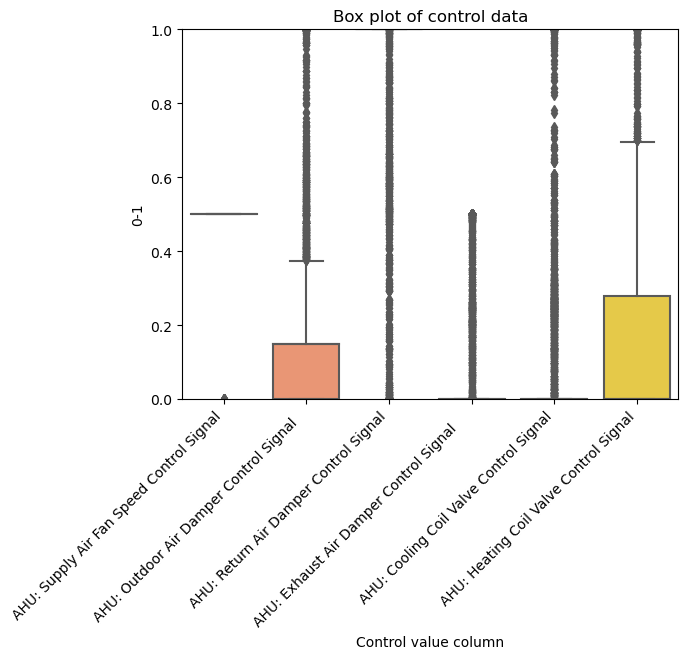

In [86]:
ax = sns.boxplot(x='Control value column', y='0-1', data=control_data, palette="Set2")
plt.title("Box plot of control data")
plt.ylim(0,1)
ax.set_xticklabels(ax.get_xticklabels(), rotation=45, horizontalalignment='right')

In [87]:
raw_data_cav.describe()

,AHU: Supply Air Temperature,AHU: Supply Air Temperature Heating Set Point,AHU: Supply Air Temperature Cooling Set Point,AHU: Outdoor Air Temperature,AHU: Mixed Air Temperature,AHU: Return Air Temperature,AHU: Supply Air Fan Status,AHU: Supply Air Fan Speed Control Signal,AHU: Outdoor Air Damper Control Signal,AHU: Return Air Damper Control Signal,AHU: Exhaust Air Damper Control Signal,AHU: Cooling Coil Valve Control Signal,AHU: Heating Coil Valve Control Signal,Occupancy Mode Indicator,Fault Detection Ground Truth
count,21510.000000,21510.000000,21510.000000,21510.000000,21510.000000,21510.000000,21510.000000,21510.000000,21510.000000,21510.000000,21510.000000,21510.000000,21510.000000,21510.000000,21510.000000
mean,68.584346,56.308631,80.418358,54.732109,65.155592,69.822446,0.999303,0.499675,0.250513,0.834856,0.082572,0.128883,0.139289,0.502092,0.933752
std,7.798999,9.889737,11.928306,5.366600,5.752576,5.199783,0.026399,0.012752,0.363272,0.365543,0.182772,0.326036,0.247166,0.500007,0.248721
min,49.210000,50.000000,50.000000,44.600000,46.280000,58.450000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,63.860000,50.000000,86.000000,50.590000,62.650000,66.180000,1.000000,0.500000,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000,1.000000
50%,67.540000,50.000000,86.000000,53.700000,65.260000,69.150000,1.000000,0.500000,0.150000,1.000000,0.000000,0.000000,0.000000,1.000000,1.000000
75%,72.540000,61.850000,86.000000,57.610000,68.000000,72.330000,1.000000,0.500000,0.150000,1.000000,0.000000,0.000000,0.279320,1.000000,1.000000
max,88.830000,86.000000,86.000000,71.180000,80.870000,83.230000,1.000000,0.500000,1.000000,1.000000,0.500000,1.000000,1.000000,1.000000,1.000000


Column "AHU: Supply Air Fan Speed Control Signal" seems to have nearly constant value therefore it is redundant. Besides that the data cleaning process appears to be successfully completed. With a clean dataset in hand, the next step is to proceed with selecting the data necassary for the purpose of model construction. This involves identifying and retaining the features that hold the most significance for the desired modeling objectives.

In [88]:
raw_data_cav.drop('AHU: Supply Air Fan Speed Control Signal', axis=1, inplace= True)

In [89]:
data_cav = raw_data_cav.copy()

<AxesSubplot:>

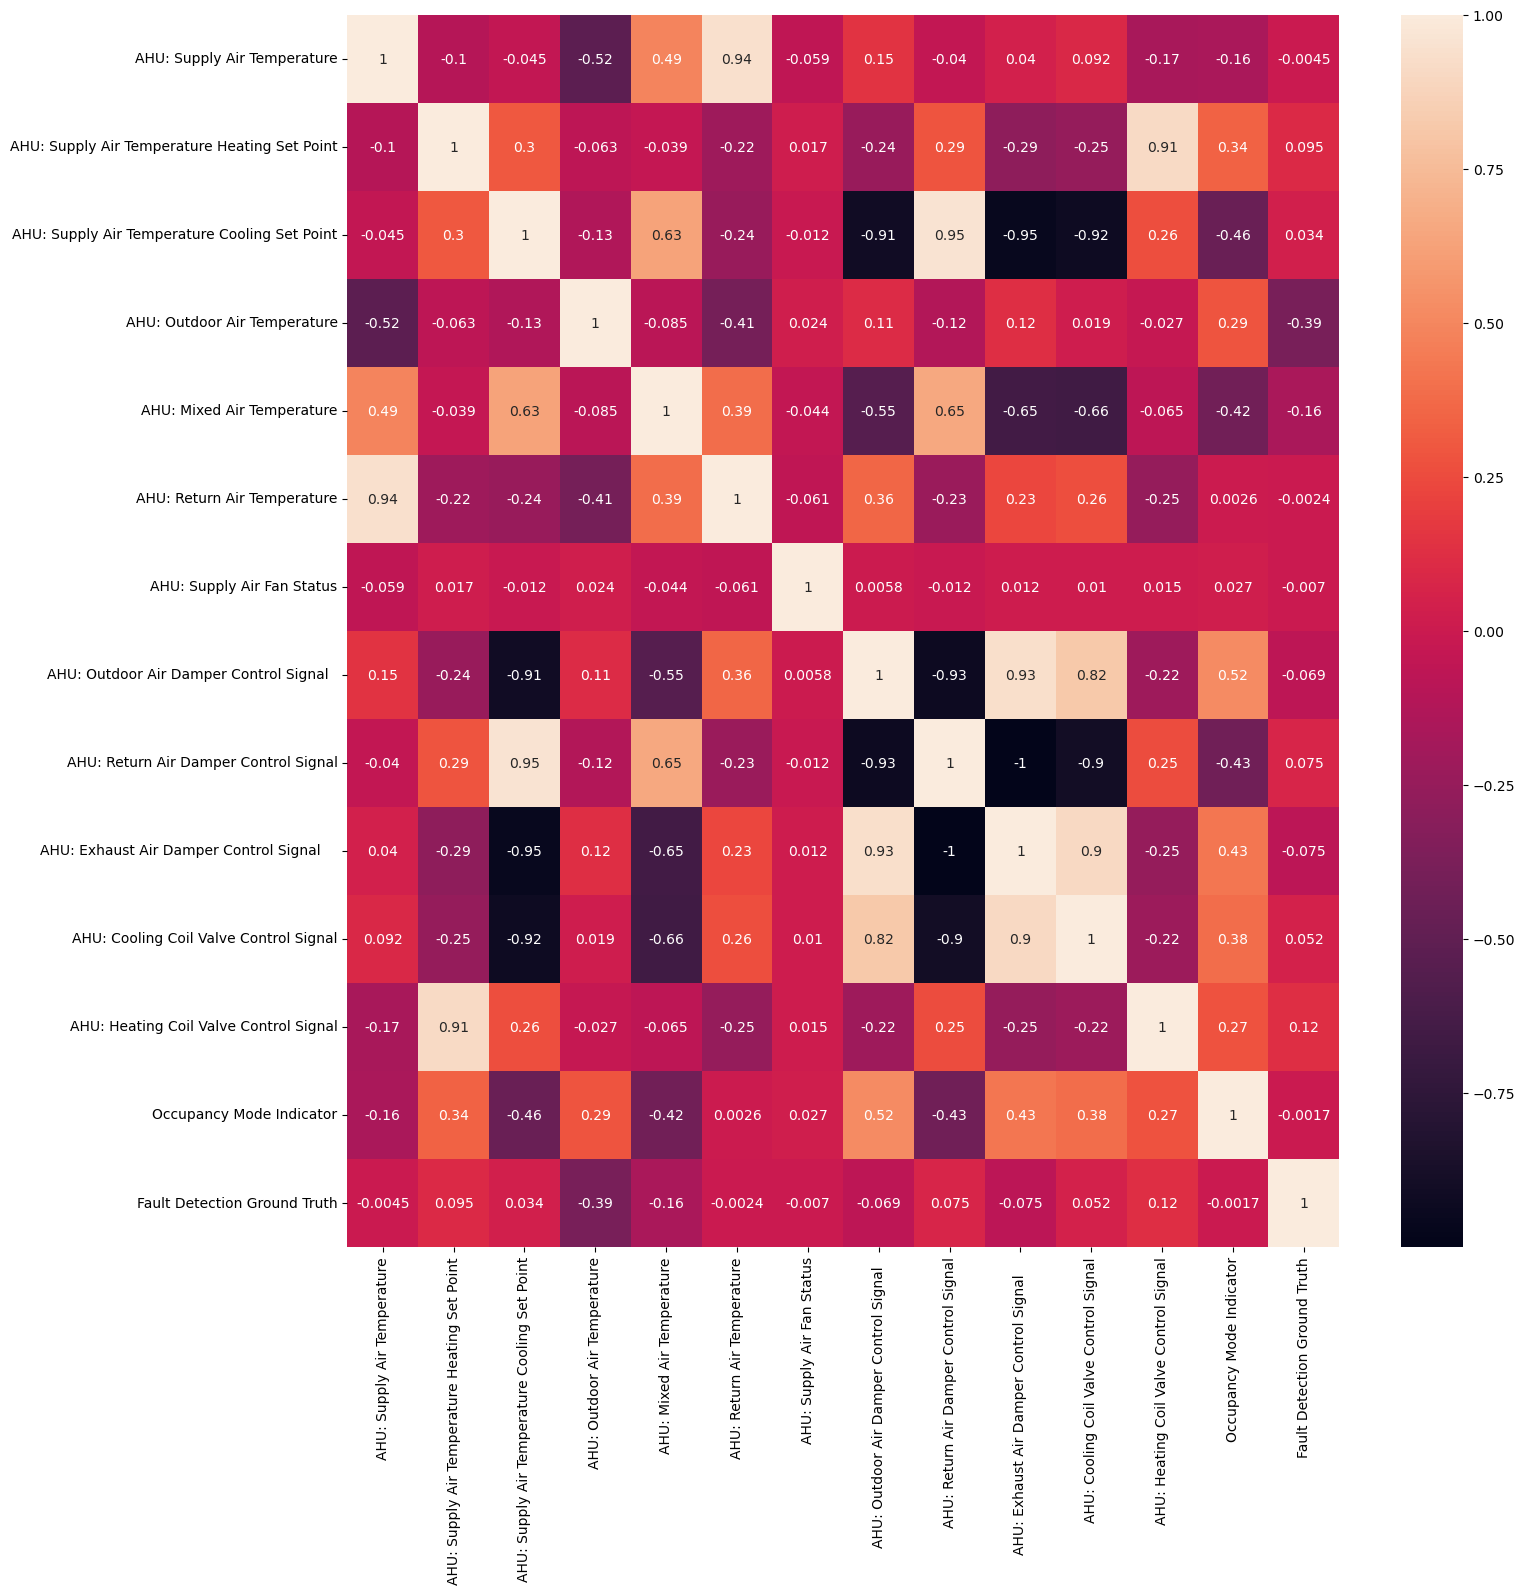

In [90]:
plt.figure(figsize=(16,16))
sns.heatmap(data_cav.corr(), annot=True)

The data analysis reveals notable correlations among the columns "AHU: Outdoor Air Damper Control Signal," "AHU: Return Air Damper Control Signal," and "AHU: Exhaust Air Damper Control Signal." To mitigate redundancy, only one of these columns will be retained.

However, the columns "AHU: Supply Air Temperature Cooling Set Point" and "AHU: Cooling Coil Valve Control Signal," despite exhibiting correlations with the columns mentioned earlier, exhibit distinct characteristics and employ different value units. As a result, these columns will be preserved for analysis, as their relevance differs from the correlated set of damper control signal columns.

In [91]:
data_cav.drop(['AHU: Return Air Damper Control Signal', 'AHU: Exhaust Air Damper Control Signal    '], axis=1, inplace=True)

<AxesSubplot:>

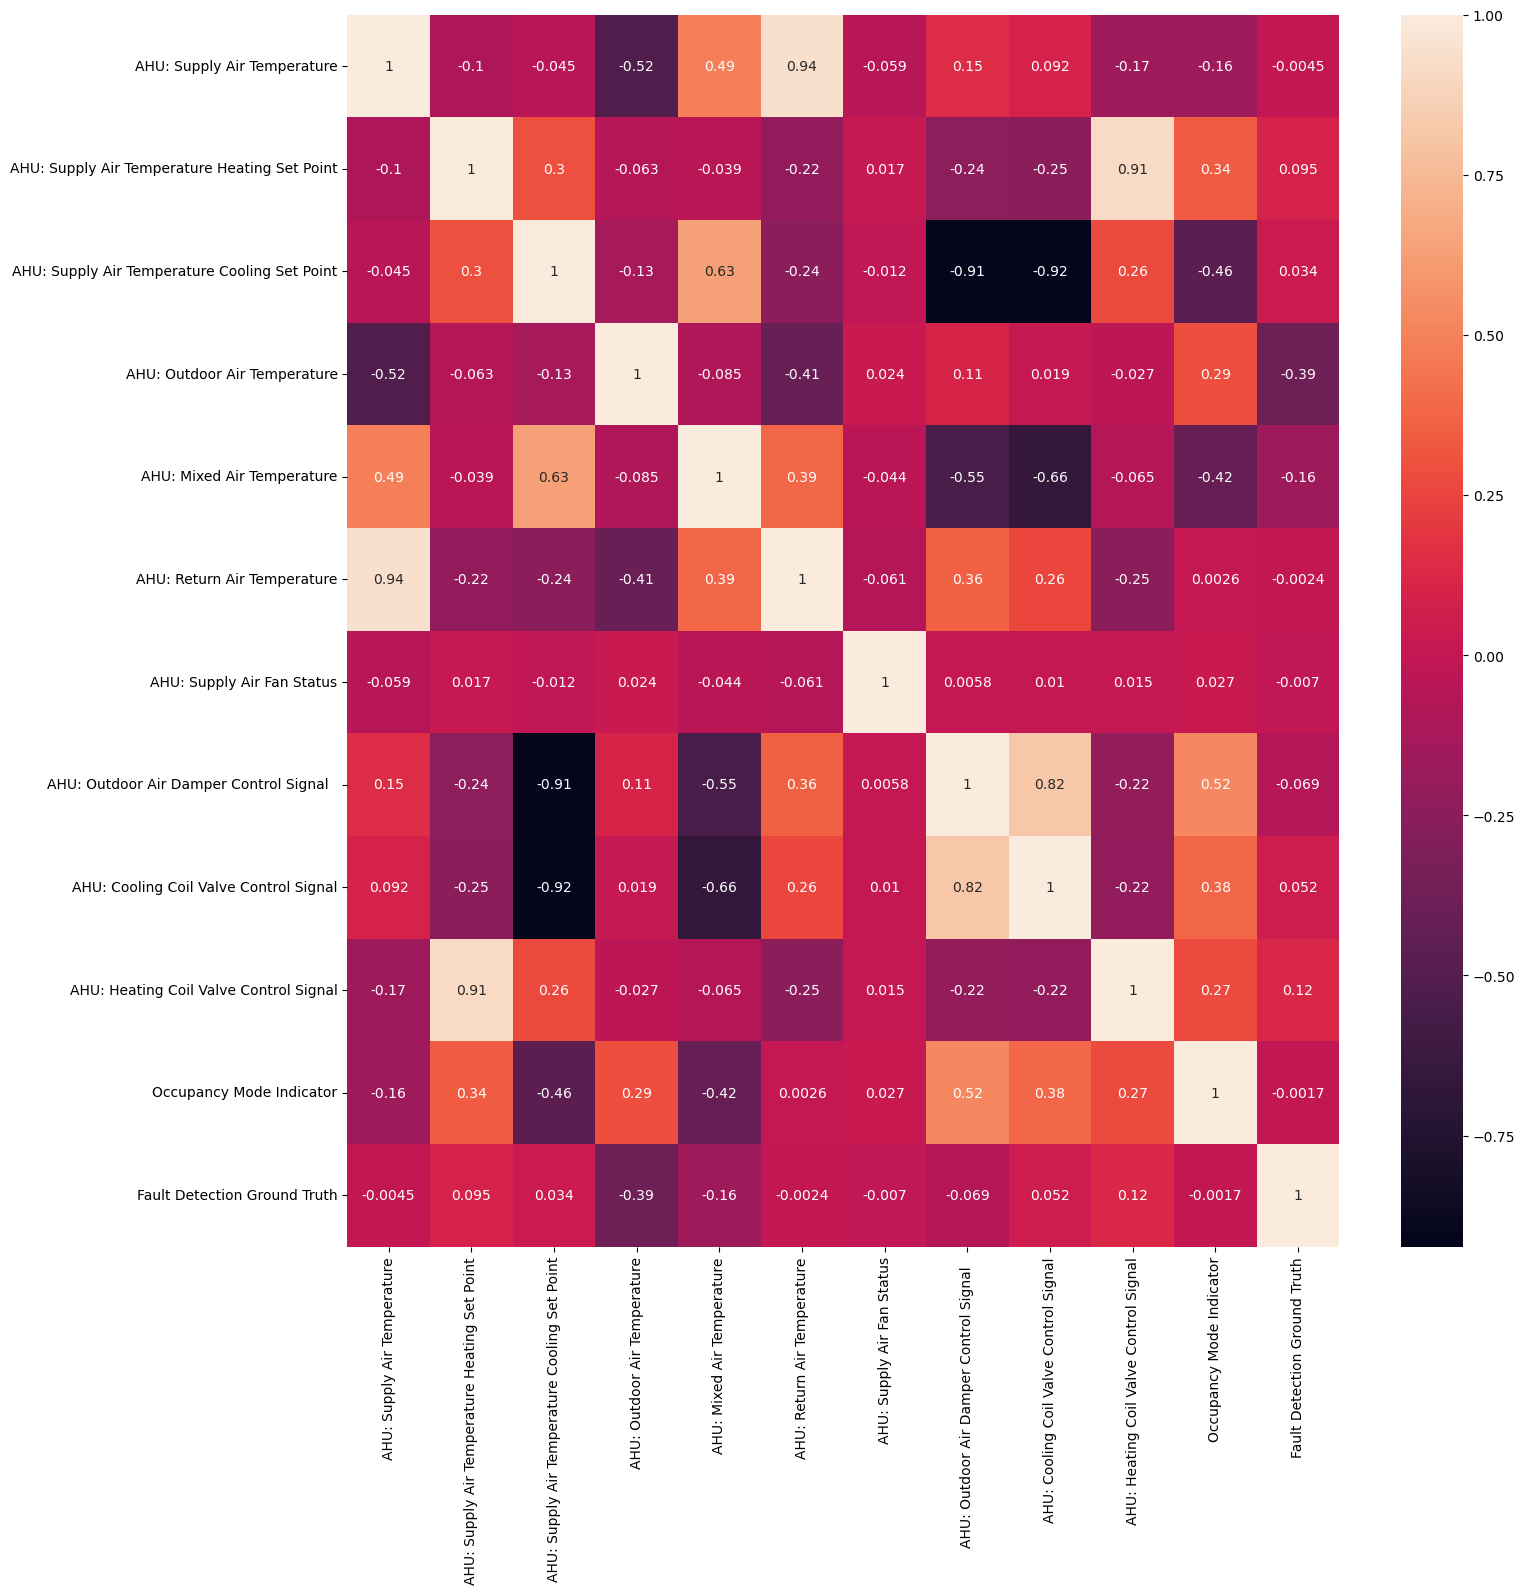

In [92]:
plt.figure(figsize=(16,16))
sns.heatmap(data_cav.corr(), annot=True)

The feature data seems ready for model construction. Regarding the "Fault Detection Ground Truth" column, its content contains a wide spectrum of distinct faults. Consequently, analogous to the other datasets, it is recommended to create separate target columns for each specific type of fault. This approach ensures that the models can effectively discern and predict the diverse fault categories present within the dataset.

In [93]:
# Creating list of dates when faults occured accordin to the description.
OA_fault_dates = [convert_date('9/18/17'), 
                  convert_date('9/19/17')]
heat_vlv_fault_dates = [convert_date('9/14/17'), 
                        convert_date('9/15/17'), 
                        convert_date('9/12/17')]
cool_vlv_fault_dates = [convert_date('9/22/17'), 
                        convert_date('9/11/17')]
OA_fault_dates = [convert_date('3/18/17'), 
                  convert_date('3/19/17'), 
                  convert_date('3/20/17'), 
                  convert_date('3/21/17')]
heat_vlv_fault_dates = [convert_date('3/24/17'), 
                        convert_date('3/25/17'), 
                        convert_date('3/26/17'),
                        convert_date('3/22/17'),
                        convert_date('3/23/17')]
cool_vlv_fault_dates = [convert_date('3/11/17'), 
                        convert_date('3/12/17'), 
                        convert_date('3/31/17'),
                        convert_date('3/15/17'),
                        convert_date('3/16/17')]

In [94]:
# Creating and filling faults column with values according to the dates given earlier.
data_cav['OA_fault'] = 0
data_cav['heat_vlv_fault'] = 0
data_cav['cool_vlv_fault'] = 0
for date in OA_fault_dates:
    data_cav.loc[data_cav['Datetime'].dt.date == date.date(), 'OA_fault'] = 1
for date in heat_vlv_fault_dates:
    data_cav.loc[data_cav['Datetime'].dt.date == date.date(), 'heat_vlv_fault'] = 1
for date in cool_vlv_fault_dates:
    data_cav.loc[data_cav['Datetime'].dt.date == date.date(), 'cool_vlv_fault'] = 1

## Models building

### Feature and target data preparation

In [95]:
X = data_cav.drop(['Datetime','Fault Detection Ground Truth', 'OA_fault','heat_vlv_fault','cool_vlv_fault'], axis=1)

In [96]:
y_oa = data_cav['OA_fault']
y_heat = data_cav['heat_vlv_fault']
y_cool = data_cav['cool_vlv_fault']

In [97]:
X_train_oa_cav, X_test_oa_cav, y_train_oa_cav, y_test_oa_cav = train_test_split(X, y_oa, test_size=0.1, shuffle=True)
X_train_heat_cav, X_test_heat_cav, y_train_heat_cav, y_test_heat_cav = train_test_split(X, y_heat, test_size=0.1, shuffle=True)
X_train_cool_cav, X_test_cool_cav, y_train_cool_cav, y_test_cool_cav = train_test_split(X, y_cool, test_size=0.1, shuffle=True)

### Classification models training

In [98]:
models_oa_cav, Acc_oa_cav = train_evaluate_classification_models(X_train_oa_cav, X_test_oa_cav, y_train_oa_cav, y_test_oa_cav, classifiers)
models_heat_cav, Acc_heat_cav = train_evaluate_classification_models(X_train_heat_cav, X_test_heat_cav, y_train_heat_cav, y_test_heat_cav, classifiers)
models_cool_cav, Acc_cool_cav = train_evaluate_classification_models(X_train_cool_cav, X_test_cool_cav, y_train_cool_cav, y_test_cool_cav, classifiers)

Learning rate set to 0.036512
0:	learn: 0.6399227	total: 15.5ms	remaining: 15.5s
1:	learn: 0.5924086	total: 24.7ms	remaining: 12.3s
2:	learn: 0.5512648	total: 34.4ms	remaining: 11.4s
3:	learn: 0.5102225	total: 43.2ms	remaining: 10.8s
4:	learn: 0.4832002	total: 58.5ms	remaining: 11.6s
5:	learn: 0.4582434	total: 68.5ms	remaining: 11.3s
6:	learn: 0.4327765	total: 77.5ms	remaining: 11s
7:	learn: 0.4136761	total: 86.4ms	remaining: 10.7s
8:	learn: 0.3940157	total: 96ms	remaining: 10.6s
9:	learn: 0.3743292	total: 105ms	remaining: 10.4s
10:	learn: 0.3565471	total: 115ms	remaining: 10.3s
11:	learn: 0.3449003	total: 124ms	remaining: 10.2s
12:	learn: 0.3285319	total: 133ms	remaining: 10.1s
13:	learn: 0.3164589	total: 144ms	remaining: 10.1s
14:	learn: 0.3033351	total: 153ms	remaining: 10s
15:	learn: 0.2952771	total: 162ms	remaining: 9.99s
16:	learn: 0.2863591	total: 172ms	remaining: 9.93s
17:	learn: 0.2772156	total: 182ms	remaining: 9.93s
18:	learn: 0.2679410	total: 194ms	remaining: 10s
19:	learn:

162:	learn: 0.0415665	total: 2.6s	remaining: 13.3s
163:	learn: 0.0412778	total: 2.61s	remaining: 13.3s
164:	learn: 0.0410300	total: 2.63s	remaining: 13.3s
165:	learn: 0.0407707	total: 2.63s	remaining: 13.2s
166:	learn: 0.0404341	total: 2.65s	remaining: 13.2s
167:	learn: 0.0401465	total: 2.66s	remaining: 13.2s
168:	learn: 0.0398141	total: 2.67s	remaining: 13.1s
169:	learn: 0.0396016	total: 2.68s	remaining: 13.1s
170:	learn: 0.0391633	total: 2.69s	remaining: 13.1s
171:	learn: 0.0389715	total: 2.71s	remaining: 13s
172:	learn: 0.0386839	total: 2.71s	remaining: 13s
173:	learn: 0.0383920	total: 2.72s	remaining: 12.9s
174:	learn: 0.0382029	total: 2.73s	remaining: 12.9s
175:	learn: 0.0380013	total: 2.75s	remaining: 12.9s
176:	learn: 0.0379118	total: 2.75s	remaining: 12.8s
177:	learn: 0.0376657	total: 2.77s	remaining: 12.8s
178:	learn: 0.0374286	total: 2.78s	remaining: 12.7s
179:	learn: 0.0372354	total: 2.79s	remaining: 12.7s
180:	learn: 0.0367273	total: 2.8s	remaining: 12.7s
181:	learn: 0.0363

333:	learn: 0.0149534	total: 4.48s	remaining: 8.94s
334:	learn: 0.0149254	total: 4.5s	remaining: 8.93s
335:	learn: 0.0148355	total: 4.51s	remaining: 8.91s
336:	learn: 0.0147978	total: 4.52s	remaining: 8.9s
337:	learn: 0.0146749	total: 4.54s	remaining: 8.88s
338:	learn: 0.0146435	total: 4.55s	remaining: 8.87s
339:	learn: 0.0145476	total: 4.56s	remaining: 8.86s
340:	learn: 0.0144643	total: 4.58s	remaining: 8.85s
341:	learn: 0.0144032	total: 4.59s	remaining: 8.83s
342:	learn: 0.0142964	total: 4.6s	remaining: 8.81s
343:	learn: 0.0141784	total: 4.62s	remaining: 8.8s
344:	learn: 0.0141577	total: 4.63s	remaining: 8.79s
345:	learn: 0.0140916	total: 4.64s	remaining: 8.78s
346:	learn: 0.0140175	total: 4.66s	remaining: 8.78s
347:	learn: 0.0139716	total: 4.68s	remaining: 8.77s
348:	learn: 0.0139033	total: 4.7s	remaining: 8.77s
349:	learn: 0.0138631	total: 4.72s	remaining: 8.76s
350:	learn: 0.0137744	total: 4.73s	remaining: 8.75s
351:	learn: 0.0137265	total: 4.74s	remaining: 8.73s
352:	learn: 0.013

503:	learn: 0.0074631	total: 6.38s	remaining: 6.28s
504:	learn: 0.0074509	total: 6.39s	remaining: 6.26s
505:	learn: 0.0074072	total: 6.4s	remaining: 6.25s
506:	learn: 0.0073803	total: 6.41s	remaining: 6.23s
507:	learn: 0.0073591	total: 6.42s	remaining: 6.22s
508:	learn: 0.0073387	total: 6.43s	remaining: 6.2s
509:	learn: 0.0072923	total: 6.44s	remaining: 6.19s
510:	learn: 0.0072752	total: 6.45s	remaining: 6.17s
511:	learn: 0.0072663	total: 6.46s	remaining: 6.16s
512:	learn: 0.0072240	total: 6.47s	remaining: 6.14s
513:	learn: 0.0071738	total: 6.48s	remaining: 6.13s
514:	learn: 0.0071310	total: 6.49s	remaining: 6.11s
515:	learn: 0.0071166	total: 6.5s	remaining: 6.1s
516:	learn: 0.0070770	total: 6.51s	remaining: 6.08s
517:	learn: 0.0070616	total: 6.52s	remaining: 6.07s
518:	learn: 0.0070226	total: 6.53s	remaining: 6.05s
519:	learn: 0.0069961	total: 6.54s	remaining: 6.04s
520:	learn: 0.0069685	total: 6.55s	remaining: 6.02s
521:	learn: 0.0069484	total: 6.56s	remaining: 6.01s
522:	learn: 0.00

673:	learn: 0.0044273	total: 8.26s	remaining: 3.99s
674:	learn: 0.0044088	total: 8.27s	remaining: 3.98s
675:	learn: 0.0043944	total: 8.28s	remaining: 3.97s
676:	learn: 0.0043830	total: 8.29s	remaining: 3.96s
677:	learn: 0.0043750	total: 8.3s	remaining: 3.94s
678:	learn: 0.0043633	total: 8.31s	remaining: 3.93s
679:	learn: 0.0043517	total: 8.32s	remaining: 3.92s
680:	learn: 0.0043373	total: 8.33s	remaining: 3.9s
681:	learn: 0.0043218	total: 8.34s	remaining: 3.89s
682:	learn: 0.0043179	total: 8.35s	remaining: 3.88s
683:	learn: 0.0042968	total: 8.36s	remaining: 3.86s
684:	learn: 0.0042834	total: 8.37s	remaining: 3.85s
685:	learn: 0.0042724	total: 8.38s	remaining: 3.84s
686:	learn: 0.0042630	total: 8.39s	remaining: 3.82s
687:	learn: 0.0042562	total: 8.4s	remaining: 3.81s
688:	learn: 0.0042481	total: 8.41s	remaining: 3.8s
689:	learn: 0.0042348	total: 8.43s	remaining: 3.79s
690:	learn: 0.0042213	total: 8.44s	remaining: 3.77s
691:	learn: 0.0042167	total: 8.44s	remaining: 3.76s
692:	learn: 0.00

855:	learn: 0.0030179	total: 10.1s	remaining: 1.7s
856:	learn: 0.0030179	total: 10.1s	remaining: 1.69s
857:	learn: 0.0030179	total: 10.1s	remaining: 1.68s
858:	learn: 0.0030179	total: 10.2s	remaining: 1.67s
859:	learn: 0.0030179	total: 10.2s	remaining: 1.65s
860:	learn: 0.0030179	total: 10.2s	remaining: 1.64s
861:	learn: 0.0030179	total: 10.2s	remaining: 1.63s
862:	learn: 0.0030179	total: 10.2s	remaining: 1.62s
863:	learn: 0.0030179	total: 10.2s	remaining: 1.6s
864:	learn: 0.0030179	total: 10.2s	remaining: 1.59s
865:	learn: 0.0030179	total: 10.2s	remaining: 1.58s
866:	learn: 0.0030179	total: 10.2s	remaining: 1.57s
867:	learn: 0.0030179	total: 10.2s	remaining: 1.55s
868:	learn: 0.0030179	total: 10.2s	remaining: 1.54s
869:	learn: 0.0030179	total: 10.2s	remaining: 1.53s
870:	learn: 0.0030179	total: 10.3s	remaining: 1.52s
871:	learn: 0.0030179	total: 10.3s	remaining: 1.51s
872:	learn: 0.0030179	total: 10.3s	remaining: 1.49s
873:	learn: 0.0030179	total: 10.3s	remaining: 1.48s
874:	learn: 0.

19:	learn: 0.1219679	total: 201ms	remaining: 9.86s
20:	learn: 0.1145073	total: 212ms	remaining: 9.89s
21:	learn: 0.1087474	total: 222ms	remaining: 9.88s
22:	learn: 0.1036457	total: 233ms	remaining: 9.9s
23:	learn: 0.0974712	total: 244ms	remaining: 9.92s
24:	learn: 0.0903991	total: 254ms	remaining: 9.92s
25:	learn: 0.0861054	total: 268ms	remaining: 10s
26:	learn: 0.0816082	total: 280ms	remaining: 10.1s
27:	learn: 0.0769677	total: 291ms	remaining: 10.1s
28:	learn: 0.0745197	total: 300ms	remaining: 10.1s
29:	learn: 0.0719175	total: 311ms	remaining: 10.1s
30:	learn: 0.0693056	total: 321ms	remaining: 10s
31:	learn: 0.0661956	total: 331ms	remaining: 10s
32:	learn: 0.0639083	total: 342ms	remaining: 10s
33:	learn: 0.0618812	total: 351ms	remaining: 9.98s
34:	learn: 0.0601840	total: 363ms	remaining: 10s
35:	learn: 0.0576353	total: 373ms	remaining: 9.99s
36:	learn: 0.0554481	total: 382ms	remaining: 9.95s
37:	learn: 0.0533826	total: 394ms	remaining: 9.98s
38:	learn: 0.0517500	total: 409ms	remainin

195:	learn: 0.0045205	total: 2.1s	remaining: 8.62s
196:	learn: 0.0044843	total: 2.11s	remaining: 8.61s
197:	learn: 0.0044518	total: 2.12s	remaining: 8.59s
198:	learn: 0.0043982	total: 2.13s	remaining: 8.58s
199:	learn: 0.0043483	total: 2.14s	remaining: 8.57s
200:	learn: 0.0043203	total: 2.15s	remaining: 8.56s
201:	learn: 0.0042979	total: 2.16s	remaining: 8.54s
202:	learn: 0.0042644	total: 2.18s	remaining: 8.55s
203:	learn: 0.0041956	total: 2.19s	remaining: 8.53s
204:	learn: 0.0041257	total: 2.2s	remaining: 8.52s
205:	learn: 0.0040607	total: 2.21s	remaining: 8.51s
206:	learn: 0.0040088	total: 2.22s	remaining: 8.5s
207:	learn: 0.0039554	total: 2.23s	remaining: 8.48s
208:	learn: 0.0039371	total: 2.24s	remaining: 8.47s
209:	learn: 0.0039141	total: 2.25s	remaining: 8.46s
210:	learn: 0.0038886	total: 2.26s	remaining: 8.44s
211:	learn: 0.0038636	total: 2.27s	remaining: 8.44s
212:	learn: 0.0038255	total: 2.28s	remaining: 8.42s
213:	learn: 0.0037940	total: 2.29s	remaining: 8.41s
214:	learn: 0.0

373:	learn: 0.0013213	total: 3.98s	remaining: 6.66s
374:	learn: 0.0013141	total: 3.99s	remaining: 6.65s
375:	learn: 0.0013142	total: 4s	remaining: 6.63s
376:	learn: 0.0013072	total: 4.01s	remaining: 6.62s
377:	learn: 0.0013072	total: 4.01s	remaining: 6.61s
378:	learn: 0.0013007	total: 4.03s	remaining: 6.6s
379:	learn: 0.0012931	total: 4.04s	remaining: 6.58s
380:	learn: 0.0012931	total: 4.04s	remaining: 6.57s
381:	learn: 0.0012931	total: 4.05s	remaining: 6.55s
382:	learn: 0.0012931	total: 4.06s	remaining: 6.54s
383:	learn: 0.0012931	total: 4.07s	remaining: 6.53s
384:	learn: 0.0012931	total: 4.08s	remaining: 6.51s
385:	learn: 0.0012834	total: 4.08s	remaining: 6.5s
386:	learn: 0.0012754	total: 4.09s	remaining: 6.49s
387:	learn: 0.0012755	total: 4.1s	remaining: 6.47s
388:	learn: 0.0012754	total: 4.11s	remaining: 6.46s
389:	learn: 0.0012754	total: 4.12s	remaining: 6.45s
390:	learn: 0.0012754	total: 4.13s	remaining: 6.43s
391:	learn: 0.0012720	total: 4.14s	remaining: 6.43s
392:	learn: 0.0012

538:	learn: 0.0012503	total: 5.42s	remaining: 4.64s
539:	learn: 0.0012503	total: 5.43s	remaining: 4.63s
540:	learn: 0.0012502	total: 5.44s	remaining: 4.62s
541:	learn: 0.0012503	total: 5.45s	remaining: 4.61s
542:	learn: 0.0012502	total: 5.46s	remaining: 4.6s
543:	learn: 0.0012503	total: 5.47s	remaining: 4.58s
544:	learn: 0.0012503	total: 5.48s	remaining: 4.57s
545:	learn: 0.0012502	total: 5.49s	remaining: 4.56s
546:	learn: 0.0012501	total: 5.49s	remaining: 4.55s
547:	learn: 0.0012503	total: 5.5s	remaining: 4.54s
548:	learn: 0.0012502	total: 5.51s	remaining: 4.53s
549:	learn: 0.0012502	total: 5.52s	remaining: 4.51s
550:	learn: 0.0012501	total: 5.53s	remaining: 4.5s
551:	learn: 0.0012501	total: 5.53s	remaining: 4.49s
552:	learn: 0.0012502	total: 5.54s	remaining: 4.48s
553:	learn: 0.0012502	total: 5.55s	remaining: 4.47s
554:	learn: 0.0012501	total: 5.56s	remaining: 4.46s
555:	learn: 0.0012502	total: 5.57s	remaining: 4.44s
556:	learn: 0.0012502	total: 5.58s	remaining: 4.43s
557:	learn: 0.0

708:	learn: 0.0012299	total: 6.86s	remaining: 2.81s
709:	learn: 0.0012299	total: 6.87s	remaining: 2.81s
710:	learn: 0.0012299	total: 6.88s	remaining: 2.79s
711:	learn: 0.0012299	total: 6.88s	remaining: 2.78s
712:	learn: 0.0012299	total: 6.89s	remaining: 2.77s
713:	learn: 0.0012299	total: 6.9s	remaining: 2.76s
714:	learn: 0.0012299	total: 6.91s	remaining: 2.75s
715:	learn: 0.0012299	total: 6.92s	remaining: 2.74s
716:	learn: 0.0012299	total: 6.93s	remaining: 2.73s
717:	learn: 0.0012299	total: 6.93s	remaining: 2.72s
718:	learn: 0.0012299	total: 6.94s	remaining: 2.71s
719:	learn: 0.0012299	total: 6.95s	remaining: 2.7s
720:	learn: 0.0012299	total: 6.96s	remaining: 2.69s
721:	learn: 0.0012299	total: 6.97s	remaining: 2.68s
722:	learn: 0.0012299	total: 6.97s	remaining: 2.67s
723:	learn: 0.0012299	total: 6.98s	remaining: 2.66s
724:	learn: 0.0012299	total: 6.99s	remaining: 2.65s
725:	learn: 0.0012299	total: 7s	remaining: 2.64s
726:	learn: 0.0012299	total: 7.01s	remaining: 2.63s
727:	learn: 0.001

871:	learn: 0.0012299	total: 8.29s	remaining: 1.22s
872:	learn: 0.0012299	total: 8.3s	remaining: 1.21s
873:	learn: 0.0012299	total: 8.32s	remaining: 1.2s
874:	learn: 0.0012299	total: 8.33s	remaining: 1.19s
875:	learn: 0.0012299	total: 8.35s	remaining: 1.18s
876:	learn: 0.0012299	total: 8.36s	remaining: 1.17s
877:	learn: 0.0012299	total: 8.37s	remaining: 1.16s
878:	learn: 0.0012299	total: 8.38s	remaining: 1.15s
879:	learn: 0.0012299	total: 8.39s	remaining: 1.14s
880:	learn: 0.0012299	total: 8.4s	remaining: 1.13s
881:	learn: 0.0012299	total: 8.41s	remaining: 1.13s
882:	learn: 0.0012299	total: 8.43s	remaining: 1.12s
883:	learn: 0.0012299	total: 8.44s	remaining: 1.11s
884:	learn: 0.0012299	total: 8.45s	remaining: 1.1s
885:	learn: 0.0012299	total: 8.46s	remaining: 1.09s
886:	learn: 0.0012299	total: 8.46s	remaining: 1.08s
887:	learn: 0.0012299	total: 8.47s	remaining: 1.07s
888:	learn: 0.0012299	total: 8.48s	remaining: 1.06s
889:	learn: 0.0012299	total: 8.49s	remaining: 1.05s
890:	learn: 0.00

38:	learn: 0.2180317	total: 415ms	remaining: 10.2s
39:	learn: 0.2138298	total: 426ms	remaining: 10.2s
40:	learn: 0.2108469	total: 436ms	remaining: 10.2s
41:	learn: 0.2079606	total: 446ms	remaining: 10.2s
42:	learn: 0.2039934	total: 455ms	remaining: 10.1s
43:	learn: 0.2004669	total: 466ms	remaining: 10.1s
44:	learn: 0.1979147	total: 477ms	remaining: 10.1s
45:	learn: 0.1943833	total: 487ms	remaining: 10.1s
46:	learn: 0.1916340	total: 498ms	remaining: 10.1s
47:	learn: 0.1898690	total: 509ms	remaining: 10.1s
48:	learn: 0.1873631	total: 518ms	remaining: 10.1s
49:	learn: 0.1844611	total: 530ms	remaining: 10.1s
50:	learn: 0.1822703	total: 542ms	remaining: 10.1s
51:	learn: 0.1801496	total: 554ms	remaining: 10.1s
52:	learn: 0.1775001	total: 566ms	remaining: 10.1s
53:	learn: 0.1757593	total: 578ms	remaining: 10.1s
54:	learn: 0.1733705	total: 591ms	remaining: 10.1s
55:	learn: 0.1709865	total: 602ms	remaining: 10.1s
56:	learn: 0.1686718	total: 614ms	remaining: 10.2s
57:	learn: 0.1668515	total: 629

206:	learn: 0.0517423	total: 2.3s	remaining: 8.8s
207:	learn: 0.0513944	total: 2.31s	remaining: 8.8s
208:	learn: 0.0512415	total: 2.32s	remaining: 8.8s
209:	learn: 0.0510045	total: 2.33s	remaining: 8.78s
210:	learn: 0.0507291	total: 2.35s	remaining: 8.77s
211:	learn: 0.0504316	total: 2.35s	remaining: 8.76s
212:	learn: 0.0503001	total: 2.37s	remaining: 8.74s
213:	learn: 0.0500163	total: 2.38s	remaining: 8.72s
214:	learn: 0.0498513	total: 2.38s	remaining: 8.71s
215:	learn: 0.0496337	total: 2.4s	remaining: 8.7s
216:	learn: 0.0492988	total: 2.41s	remaining: 8.68s
217:	learn: 0.0490152	total: 2.42s	remaining: 8.67s
218:	learn: 0.0488923	total: 2.43s	remaining: 8.66s
219:	learn: 0.0486011	total: 2.44s	remaining: 8.64s
220:	learn: 0.0484052	total: 2.45s	remaining: 8.63s
221:	learn: 0.0481678	total: 2.46s	remaining: 8.61s
222:	learn: 0.0479362	total: 2.47s	remaining: 8.6s
223:	learn: 0.0476651	total: 2.48s	remaining: 8.58s
224:	learn: 0.0474487	total: 2.49s	remaining: 8.57s
225:	learn: 0.04723

380:	learn: 0.0230962	total: 4.18s	remaining: 6.79s
381:	learn: 0.0229439	total: 4.19s	remaining: 6.78s
382:	learn: 0.0228648	total: 4.2s	remaining: 6.77s
383:	learn: 0.0227946	total: 4.21s	remaining: 6.75s
384:	learn: 0.0227042	total: 4.22s	remaining: 6.74s
385:	learn: 0.0226381	total: 4.23s	remaining: 6.73s
386:	learn: 0.0225493	total: 4.24s	remaining: 6.72s
387:	learn: 0.0224832	total: 4.25s	remaining: 6.71s
388:	learn: 0.0223492	total: 4.26s	remaining: 6.7s
389:	learn: 0.0223056	total: 4.28s	remaining: 6.69s
390:	learn: 0.0222286	total: 4.28s	remaining: 6.67s
391:	learn: 0.0221251	total: 4.29s	remaining: 6.66s
392:	learn: 0.0219966	total: 4.3s	remaining: 6.65s
393:	learn: 0.0219158	total: 4.31s	remaining: 6.64s
394:	learn: 0.0218131	total: 4.32s	remaining: 6.62s
395:	learn: 0.0217859	total: 4.34s	remaining: 6.61s
396:	learn: 0.0216621	total: 4.34s	remaining: 6.6s
397:	learn: 0.0215867	total: 4.36s	remaining: 6.59s
398:	learn: 0.0214992	total: 4.37s	remaining: 6.58s
399:	learn: 0.02

549:	learn: 0.0128364	total: 6.11s	remaining: 5s
550:	learn: 0.0128140	total: 6.12s	remaining: 4.99s
551:	learn: 0.0127757	total: 6.13s	remaining: 4.98s
552:	learn: 0.0126775	total: 6.14s	remaining: 4.97s
553:	learn: 0.0126280	total: 6.16s	remaining: 4.96s
554:	learn: 0.0125409	total: 6.16s	remaining: 4.94s
555:	learn: 0.0125325	total: 6.17s	remaining: 4.93s
556:	learn: 0.0124827	total: 6.18s	remaining: 4.92s
557:	learn: 0.0124398	total: 6.2s	remaining: 4.91s
558:	learn: 0.0123700	total: 6.21s	remaining: 4.9s
559:	learn: 0.0123310	total: 6.22s	remaining: 4.88s
560:	learn: 0.0123094	total: 6.23s	remaining: 4.87s
561:	learn: 0.0122568	total: 6.24s	remaining: 4.86s
562:	learn: 0.0122096	total: 6.25s	remaining: 4.85s
563:	learn: 0.0121818	total: 6.26s	remaining: 4.84s
564:	learn: 0.0121405	total: 6.27s	remaining: 4.83s
565:	learn: 0.0121059	total: 6.29s	remaining: 4.82s
566:	learn: 0.0120543	total: 6.3s	remaining: 4.81s
567:	learn: 0.0120188	total: 6.32s	remaining: 4.81s
568:	learn: 0.0119

723:	learn: 0.0079457	total: 8.41s	remaining: 3.21s
724:	learn: 0.0079158	total: 8.42s	remaining: 3.19s
725:	learn: 0.0078962	total: 8.43s	remaining: 3.18s
726:	learn: 0.0078914	total: 8.44s	remaining: 3.17s
727:	learn: 0.0078738	total: 8.45s	remaining: 3.16s
728:	learn: 0.0078550	total: 8.47s	remaining: 3.15s
729:	learn: 0.0078214	total: 8.48s	remaining: 3.13s
730:	learn: 0.0077948	total: 8.49s	remaining: 3.12s
731:	learn: 0.0077797	total: 8.5s	remaining: 3.11s
732:	learn: 0.0077705	total: 8.51s	remaining: 3.1s
733:	learn: 0.0077464	total: 8.52s	remaining: 3.09s
734:	learn: 0.0077314	total: 8.53s	remaining: 3.08s
735:	learn: 0.0077197	total: 8.54s	remaining: 3.06s
736:	learn: 0.0076905	total: 8.55s	remaining: 3.05s
737:	learn: 0.0076765	total: 8.57s	remaining: 3.04s
738:	learn: 0.0076492	total: 8.58s	remaining: 3.03s
739:	learn: 0.0076266	total: 8.59s	remaining: 3.02s
740:	learn: 0.0076152	total: 8.6s	remaining: 3.01s
741:	learn: 0.0076106	total: 8.61s	remaining: 3s
742:	learn: 0.0075

892:	learn: 0.0055193	total: 10.3s	remaining: 1.24s
893:	learn: 0.0055100	total: 10.3s	remaining: 1.23s
894:	learn: 0.0054955	total: 10.4s	remaining: 1.21s
895:	learn: 0.0054853	total: 10.4s	remaining: 1.2s
896:	learn: 0.0054642	total: 10.4s	remaining: 1.19s
897:	learn: 0.0054474	total: 10.4s	remaining: 1.18s
898:	learn: 0.0054376	total: 10.4s	remaining: 1.17s
899:	learn: 0.0054242	total: 10.4s	remaining: 1.16s
900:	learn: 0.0054164	total: 10.4s	remaining: 1.14s
901:	learn: 0.0054054	total: 10.4s	remaining: 1.13s
902:	learn: 0.0053844	total: 10.4s	remaining: 1.12s
903:	learn: 0.0053770	total: 10.4s	remaining: 1.11s
904:	learn: 0.0053605	total: 10.5s	remaining: 1.1s
905:	learn: 0.0053526	total: 10.5s	remaining: 1.09s
906:	learn: 0.0053322	total: 10.5s	remaining: 1.07s
907:	learn: 0.0053277	total: 10.5s	remaining: 1.06s
908:	learn: 0.0053182	total: 10.5s	remaining: 1.05s
909:	learn: 0.0053090	total: 10.5s	remaining: 1.04s
910:	learn: 0.0052995	total: 10.5s	remaining: 1.03s
911:	learn: 0.

## Models evaluation

In [99]:
print(Acc_oa_cav)

                        model  train_accuracy  test_accuracy  train_precision  \
0        KNeighborsClassifier        0.998915       0.997211         0.997299   
1               MLPClassifier        0.977530       0.980009         0.943167   
2          AdaBoostClassifier        0.950772       0.948396         0.898171   
3  GradientBoostingClassifier        0.980061       0.981404         0.952399   
4          CatBoostClassifier        1.000000       0.998140         1.000000   
5               XGBClassifier        1.000000       0.997675         1.000000   
6           BaggingClassifier        0.999793       0.997211         0.999421   
7      RandomForestClassifier        1.000000       0.999535         1.000000   
8      DecisionTreeClassifier        1.000000       0.997211         1.000000   
9          LogisticRegression        0.777261       0.788470         0.630514   

   test_precision  train_recall  test_recall  train_f1   test_f1  
0        0.994728      0.998648     0.994

In [100]:
print(Acc_heat_cav)

                        model  train_accuracy  test_accuracy  train_precision  \
0        KNeighborsClassifier        0.999587       0.999070         0.998917   
1               MLPClassifier        0.986673       0.985123         0.972409   
2          AdaBoostClassifier        0.989721       0.986518         0.985264   
3  GradientBoostingClassifier        0.997934       0.997211         0.997982   
4          CatBoostClassifier        1.000000       0.999535         1.000000   
5               XGBClassifier        1.000000       0.999535         1.000000   
6           BaggingClassifier        0.999948       0.998605         0.999845   
7      RandomForestClassifier        1.000000       1.000000         1.000000   
8      DecisionTreeClassifier        1.000000       0.997211         1.000000   
9          LogisticRegression        0.930575       0.917713         0.905457   

   test_precision  train_recall  test_recall  train_f1   test_f1  
0        0.998599      0.999845     0.998

In [101]:
print(Acc_cool_cav)

                        model  train_accuracy  test_accuracy  train_precision  \
0        KNeighborsClassifier        0.998089       0.997675         0.998607   
1               MLPClassifier        0.944677       0.942352         0.917683   
2          AdaBoostClassifier        0.903869       0.897722         0.876079   
3  GradientBoostingClassifier        0.969420       0.966527         0.971493   
4          CatBoostClassifier        0.999897       1.000000         0.999846   
5               XGBClassifier        1.000000       0.999535         1.000000   
6           BaggingClassifier        0.999948       0.997675         1.000000   
7      RandomForestClassifier        1.000000       0.999535         1.000000   
8      DecisionTreeClassifier        1.000000       0.994421         1.000000   
9          LogisticRegression        0.807376       0.800093         0.787461   

   test_precision  train_recall  test_recall  train_f1   test_f1  
0        1.000000      0.995679     0.992

The majority of the models have demonstrated exceptional performance even without undergoing tuning or balancing procedures. With such high levels of performance achieved, selecting the best model becomes a challenging task, as many of them seem equally proficient. It's reasonable to consider practical considerations when making a choice, such as selecting the model that exhibits the fastest execution time and occupies the least storage space. These attributes can enhance the model's operational efficiency and facilitate its integration into real-world applications.

# Single-zone variable air volume AHU

## Data exploration and feature engineering

In [102]:
raw_data_vav.sample(5)

,Datetime,AHU: Supply Air Temperature,AHU: Supply Air Temperature Heating Set Point,AHU: Supply Air Temperature Cooling Set Point,AHU: Outdoor Air Temperature,AHU: Mixed Air Temperature,AHU: Return Air Temperature,AHU: Supply Air Fan Status,AHU: Supply Air Fan Speed Control Signal,AHU: Outdoor Air Damper Control Signal,AHU: Return Air Damper Control Signal,AHU: Exhaust Air Damper Control Signal,AHU: Cooling Coil Valve Control Signal,AHU: Heating Coil Valve Control Signal,Occupancy Mode Indicator,Fault Detection Ground Truth
8183,9/19/2017 16:23,54.00,53.04,55.04,71.57,70.83,71.33,1,0.27,1.0,0.0,0.90,0.31,0.00,1,1
5038,9/15/2017 11:58,73.02,53.04,55.04,69.7,70.59,83.78,1,0.50,1.0,0.0,0.90,1.00,0.00,1,1
1586,9/12/2017 2:26,103.15,72.50,72.50,71.27,72.16,77.80,1,0.10,1.0,0.0,0.90,0.00,0.00,0,1
20,9/11/2017 0:20,72.05,NaN,NaN,80.82,77.86,76.06,1,0.10,0.0,1.0,-0.04,0.00,0.26,0,1
11360,9/21/2017 21:20,71.19,72.50,72.50,56.65,75.69,73.29,1,0.10,0.0,1.0,-0.04,0.00,0.10,0,0


In [103]:
raw_data_vav.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 15839 entries, 0 to 15838
Data columns (total 16 columns):
 #   Column                                         Non-Null Count  Dtype  
---  ------                                         --------------  -----  
 0   Datetime                                       15839 non-null  object 
 1   AHU: Supply Air Temperature                    15839 non-null  float64
 2   AHU: Supply Air Temperature Heating Set Point  15249 non-null  float64
 3   AHU: Supply Air Temperature Cooling Set Point  15249 non-null  float64
 4   AHU: Outdoor Air Temperature                   15839 non-null  object 
 5   AHU: Mixed Air Temperature                     15839 non-null  float64
 6   AHU: Return Air Temperature                    15839 non-null  float64
 7   AHU: Supply Air Fan Status                     15839 non-null  int64  
 8   AHU: Supply Air Fan Speed Control Signal       15839 non-null  float64
 9   AHU: Outdoor Air Damper Control Signal         158

The columns "AHU: Supply Air Temperature Heating Set Point" and "AHU: Supply Air Temperature Cooling Set Point" exhibit a minor number of null values relative to the dataset's size. Given this proportion, the approach of dropping rows containing null values is appropriate to maintain data integrity.

Moreover, it appears that the "AHU: Outdoor Air Temperature" column is recorded as an object data type. To ensure accurate numerical analysis, it will be essential to transform this column into a numeric data type.

Additionally, the "Datetime" column warrants transformation into the DateTime format to facilitate consistent handling of temporal information within the dataset. These data transformations are essential to ensuring uniformity and reliability in subsequent analysis and modeling steps.

In [104]:
raw_data_vav['Datetime'] = pd.to_datetime(raw_data_vav['Datetime'])

In [105]:
# Changing column values to numeric values, changing all defective data to NaN
raw_data_vav['AHU: Outdoor Air Temperature'] = pd.to_numeric(raw_data_vav['AHU: Outdoor Air Temperature'],errors='coerce')

In [106]:
raw_data_vav['AHU: Outdoor Air Temperature'].isna().sum()

1

It appears that column contain only a single defective value. As a precautionary measure, it is advisable to remove this particular row.

In [107]:
# Removing all rows with null data
raw_data_vav.dropna(inplace=True)

In [108]:
raw_data_vav.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 15248 entries, 590 to 15838
Data columns (total 16 columns):
 #   Column                                         Non-Null Count  Dtype         
---  ------                                         --------------  -----         
 0   Datetime                                       15248 non-null  datetime64[ns]
 1   AHU: Supply Air Temperature                    15248 non-null  float64       
 2   AHU: Supply Air Temperature Heating Set Point  15248 non-null  float64       
 3   AHU: Supply Air Temperature Cooling Set Point  15248 non-null  float64       
 4   AHU: Outdoor Air Temperature                   15248 non-null  float64       
 5   AHU: Mixed Air Temperature                     15248 non-null  float64       
 6   AHU: Return Air Temperature                    15248 non-null  float64       
 7   AHU: Supply Air Fan Status                     15248 non-null  int64         
 8   AHU: Supply Air Fan Speed Control Signal       15248 n

With the data cleaning phase successfully completed, the next step involves the selection of pertinent features for the purpose of model construction

In [109]:
# Preparing datasets for Boxplot visualisation
temp_col = [col for col in raw_data_vav.columns if "Temp" in col]
control_col = [col for col in raw_data_vav.columns if "Control" in col]
temp_data = raw_data_vav[temp_col].melt(var_name='Temperature column', value_name='Temperature in Fahrenheit')
control_data = raw_data_vav[control_col].melt(var_name='Control value column', value_name='0-1')

[Text(0, 0, 'AHU: Supply Air Temperature'),
 Text(1, 0, 'AHU: Supply Air Temperature Heating Set Point'),
 Text(2, 0, 'AHU: Supply Air Temperature Cooling Set Point'),
 Text(3, 0, 'AHU: Outdoor Air Temperature'),
 Text(4, 0, 'AHU: Mixed Air Temperature'),
 Text(5, 0, 'AHU: Return Air Temperature')]

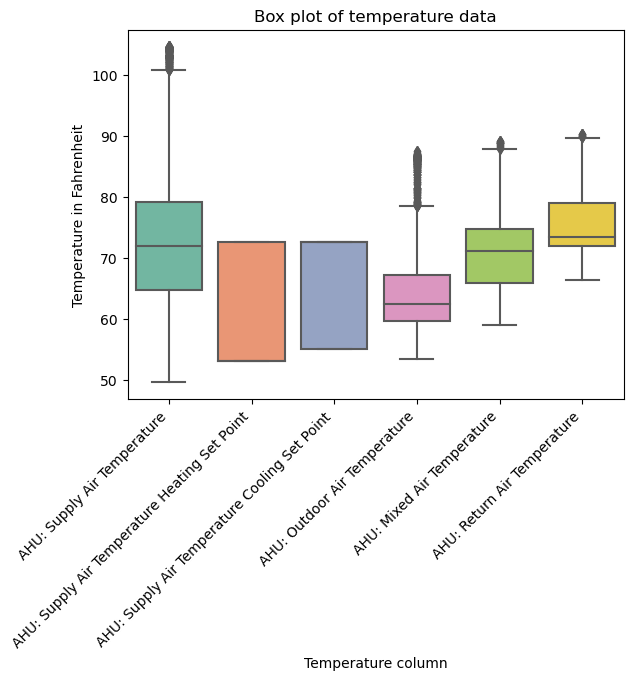

In [110]:
ax = sns.boxplot(x='Temperature column', y='Temperature in Fahrenheit', data=temp_data, palette="Set2")
plt.title("Box plot of temperature data")
ax.set_xticklabels(ax.get_xticklabels(), rotation=45, horizontalalignment='right')

[Text(0, 0, 'AHU: Supply Air Fan Speed Control Signal'),
 Text(1, 0, 'AHU: Outdoor Air Damper Control Signal  '),
 Text(2, 0, 'AHU: Return Air Damper Control Signal'),
 Text(3, 0, 'AHU: Exhaust Air Damper Control Signal    '),
 Text(4, 0, 'AHU: Cooling Coil Valve Control Signal'),
 Text(5, 0, 'AHU: Heating Coil Valve Control Signal')]

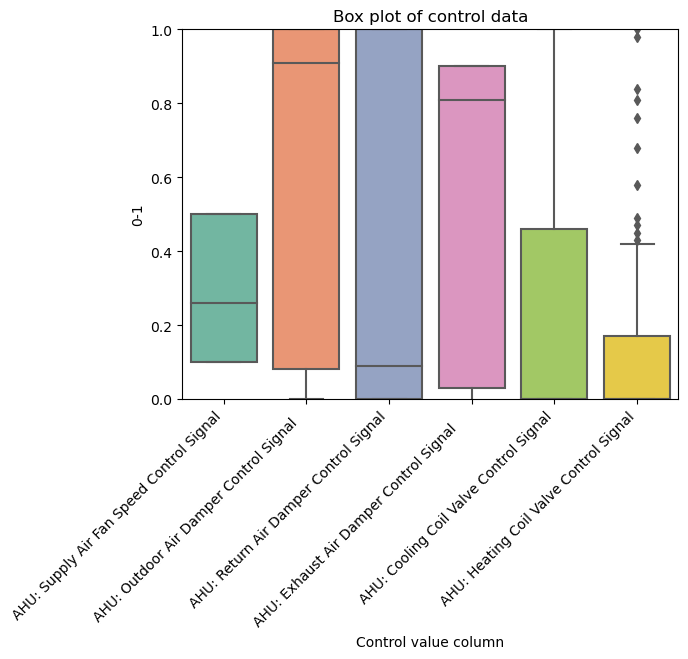

In [111]:
ax = sns.boxplot(x='Control value column', y='0-1', data=control_data, palette="Set2")
plt.title("Box plot of control data")
plt.ylim(0,1)
ax.set_xticklabels(ax.get_xticklabels(), rotation=45, horizontalalignment='right')

In [112]:
raw_data_vav.describe()

,AHU: Supply Air Temperature,AHU: Supply Air Temperature Heating Set Point,AHU: Supply Air Temperature Cooling Set Point,AHU: Outdoor Air Temperature,AHU: Mixed Air Temperature,AHU: Return Air Temperature,AHU: Supply Air Fan Status,AHU: Supply Air Fan Speed Control Signal,AHU: Outdoor Air Damper Control Signal,AHU: Return Air Damper Control Signal,AHU: Exhaust Air Damper Control Signal,AHU: Cooling Coil Valve Control Signal,AHU: Heating Coil Valve Control Signal,Occupancy Mode Indicator,Fault Detection Ground Truth
count,15248.000000,15248.000000,15248.000000,15248.000000,15248.000000,15248.000000,15248.0,15248.000000,15248.000000,15248.000000,15248.000000,15248.000000,15248.000000,15248.000000,15248.000000
mean,71.404984,61.808934,65.478933,63.636067,70.335233,75.114075,1.0,0.279842,0.549380,0.471283,0.479826,0.301201,0.067424,0.504328,0.622311
std,11.363049,9.612359,8.260445,5.989430,5.238168,4.861249,0.0,0.179529,0.463552,0.483852,0.432596,0.411731,0.107855,0.499998,0.484825
min,49.550000,53.040000,55.040000,53.310000,58.990000,66.330000,1.0,0.100000,0.000000,0.000000,-0.040000,0.000000,0.000000,0.000000,0.000000
25%,64.620000,53.040000,55.040000,59.560000,65.910000,71.880000,1.0,0.100000,0.080000,0.000000,0.030000,0.000000,0.000000,0.000000,0.000000
50%,71.920000,53.040000,72.500000,62.440000,71.050000,73.330000,1.0,0.260000,0.910000,0.090000,0.810000,0.000000,0.000000,1.000000,1.000000
75%,79.062500,72.500000,72.500000,67.140000,74.670000,78.982500,1.0,0.500000,1.000000,1.000000,0.900000,0.460000,0.170000,1.000000,1.000000
max,104.640000,72.500000,72.500000,87.520000,89.100000,90.280000,1.0,0.500000,1.000000,1.000000,0.900000,1.000000,1.000000,1.000000,1.000000


The "AHU: Supply Air Fan Status" column with constant values will be excluded from the dataset. Besides that all data seems to be correct.

In [113]:
# Making copy of dataset for further data transformation
data_vav = raw_data_vav.copy()

In [114]:
data_vav.drop('AHU: Supply Air Fan Status',axis=1, inplace=True)

<AxesSubplot:>

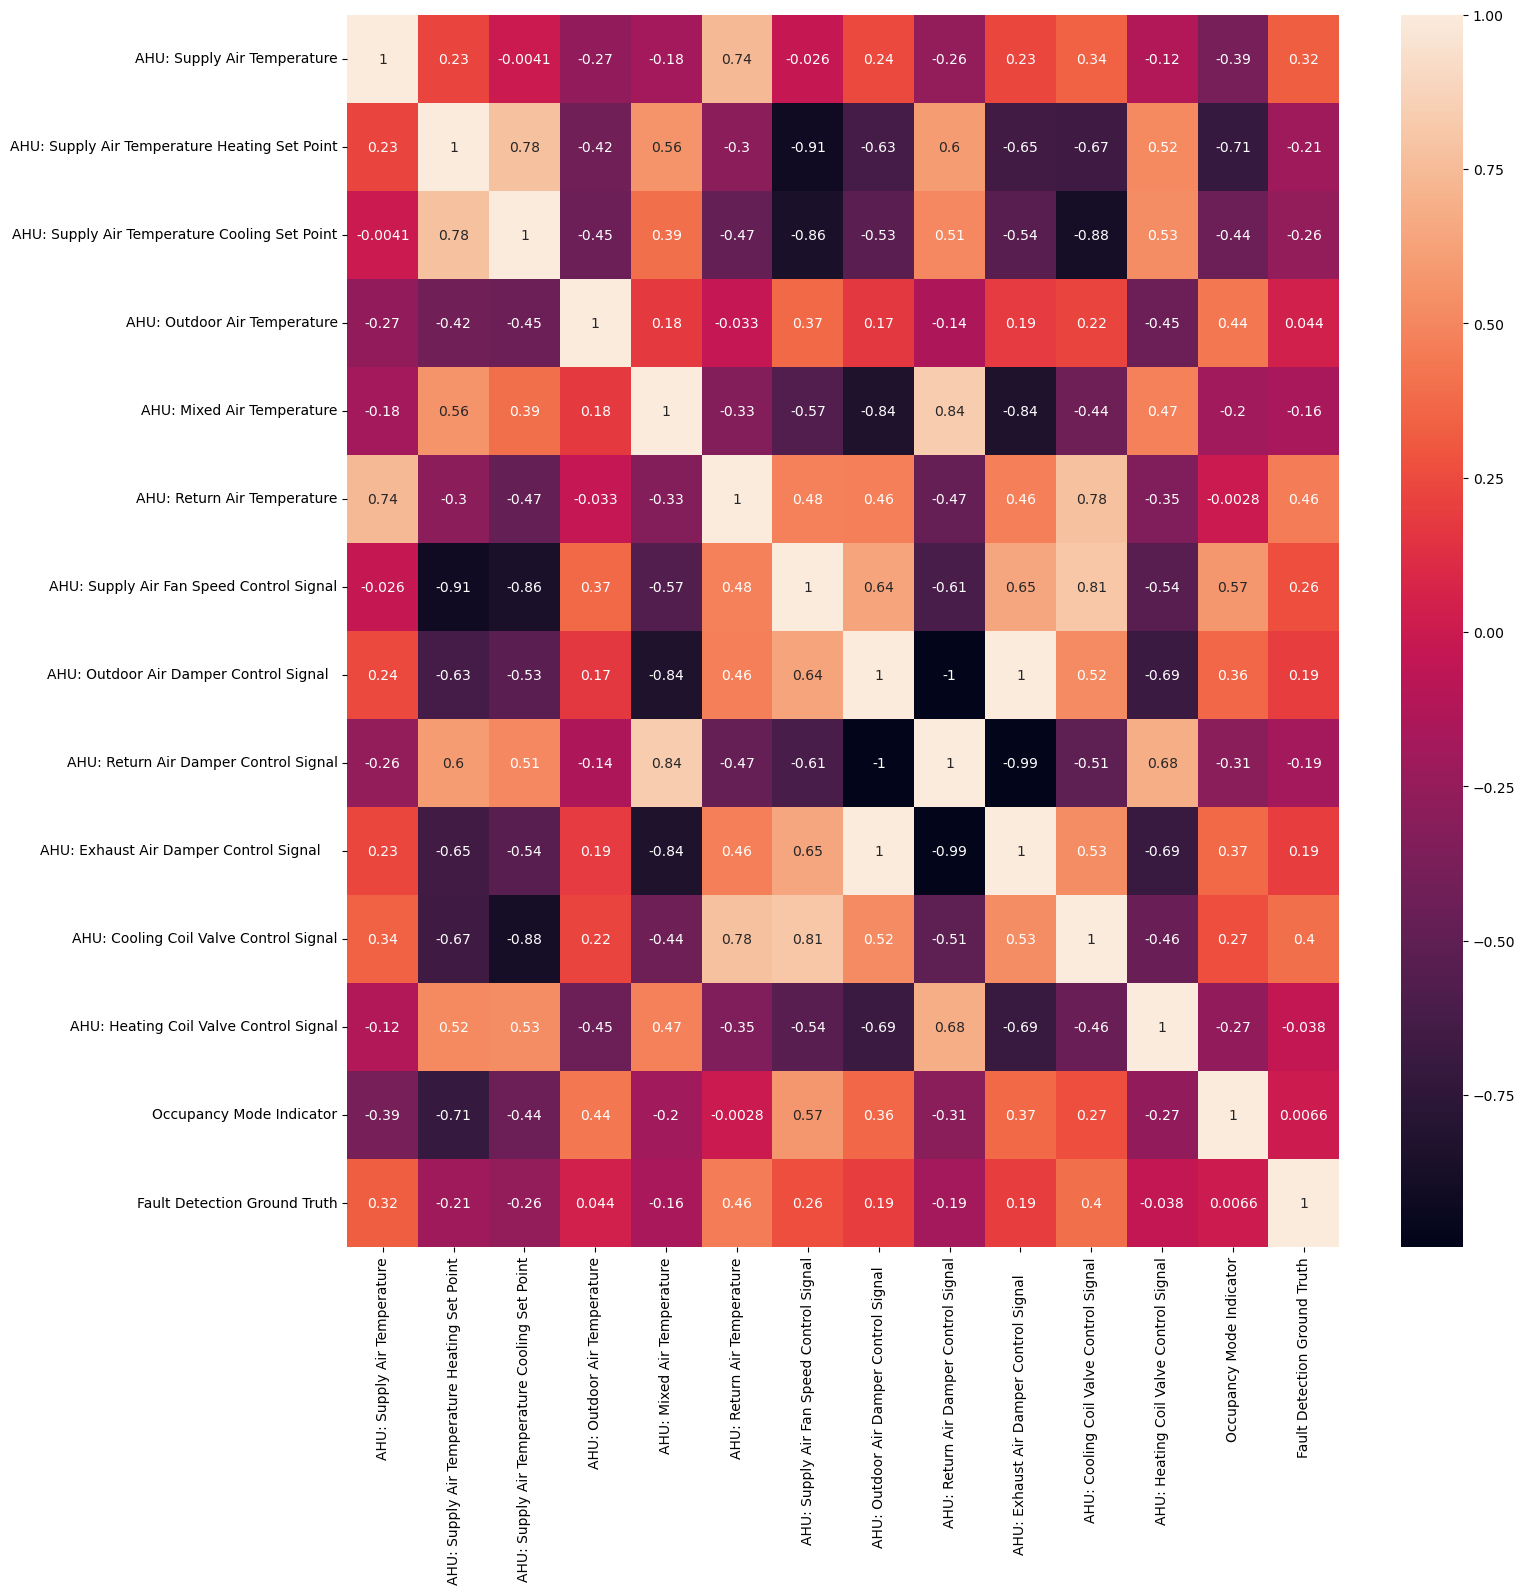

In [115]:
plt.figure(figsize=(16,16))
sns.heatmap(data_vav.corr(), annot=True)

In this dataset there is high correlation among three columns: "AHU: Outdoor Air Damper Control Signal," "AHU: Return Air Damper Control Signal," and "AHU: Exhaust Air Damper Control Signal." This correlation suggests that retaining all three columns might introduce multicollinearity.

In [116]:
data_vav.drop(['AHU: Return Air Damper Control Signal', 'AHU: Exhaust Air Damper Control Signal    '], axis=1, inplace=True)

<AxesSubplot:>

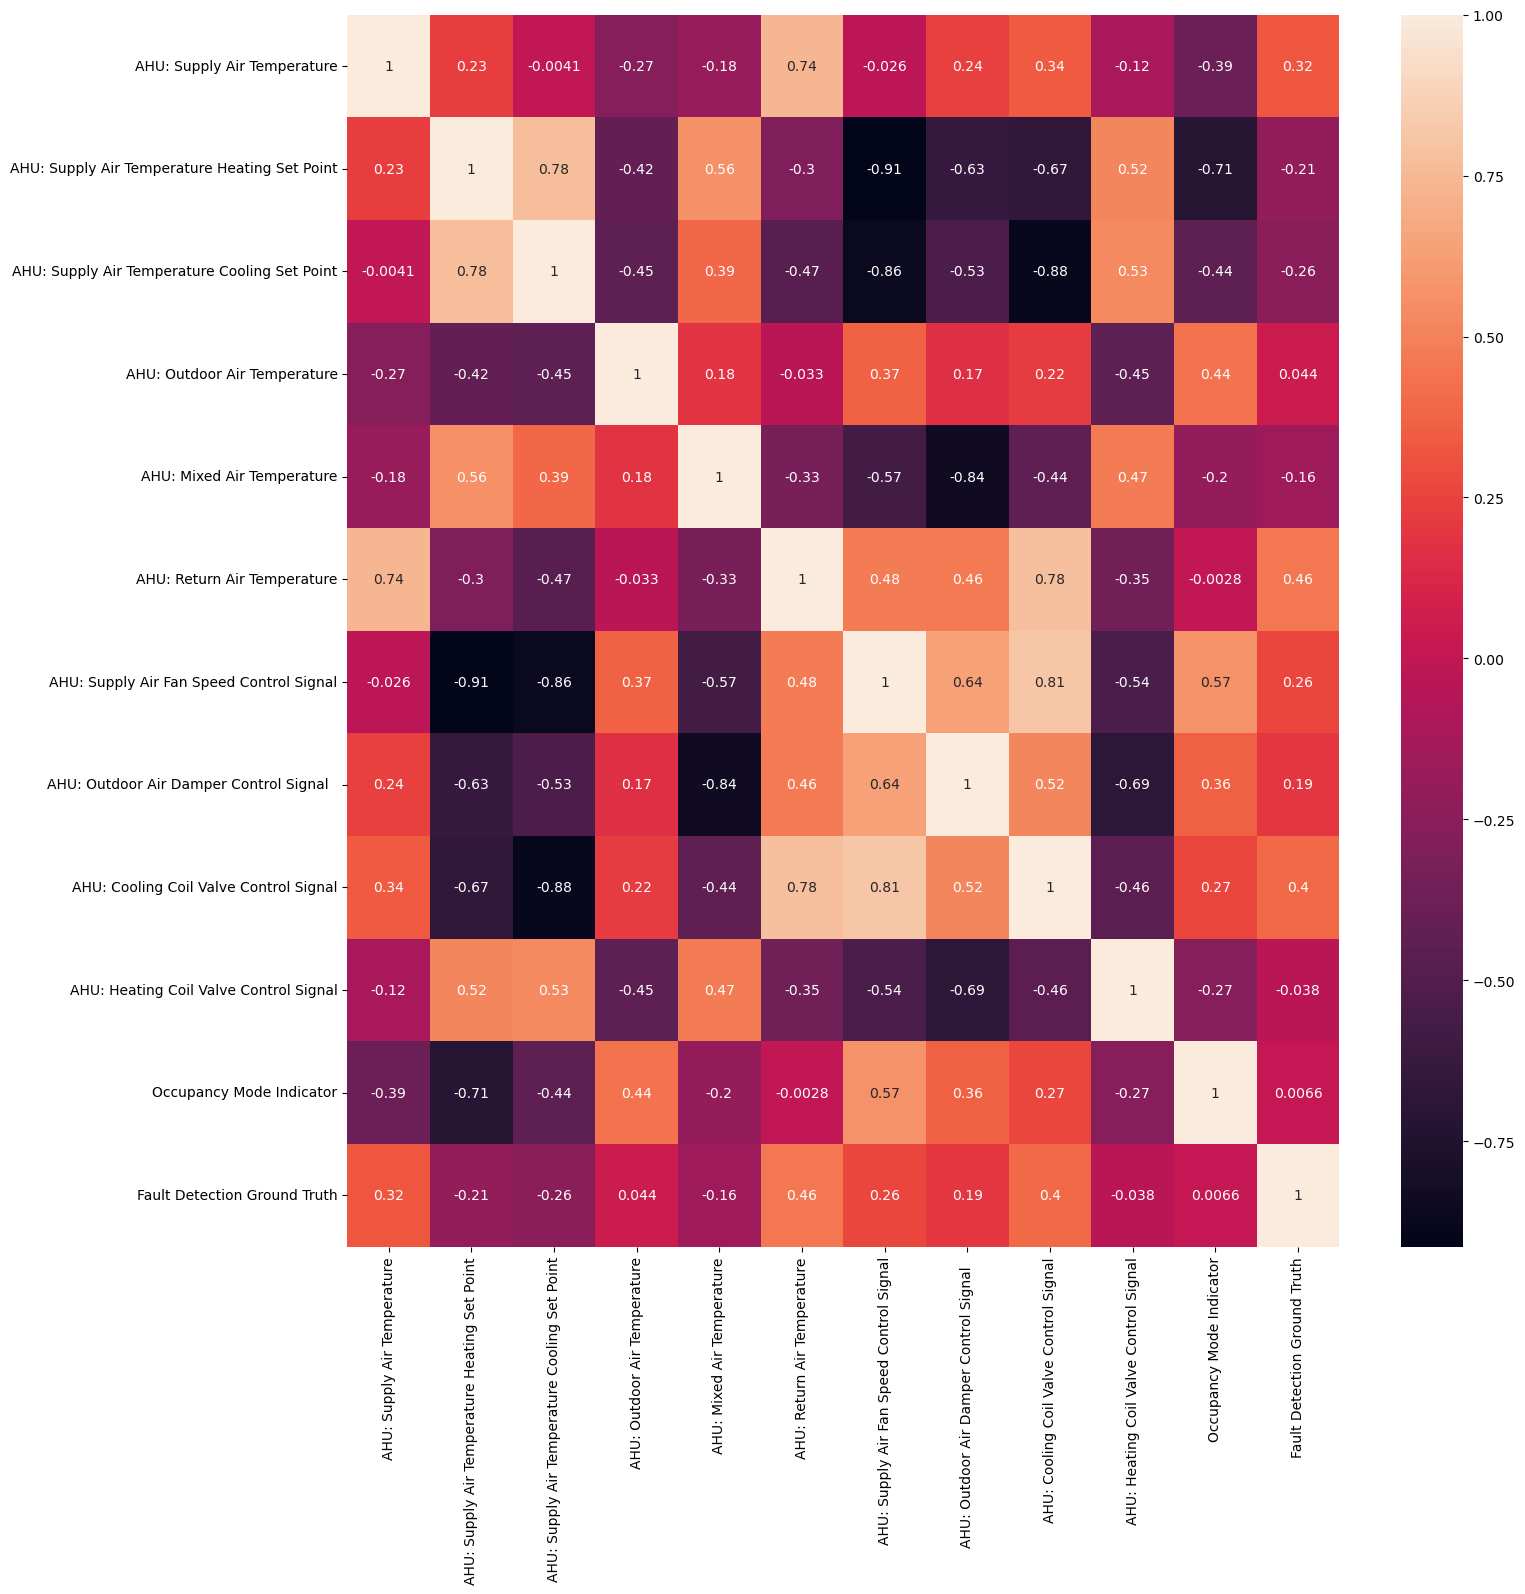

In [117]:
plt.figure(figsize=(16,16))
sns.heatmap(data_vav.corr(), annot=True)

The dataset is now poised for the model building phase. Notably, the "Fault Detection Ground Truth" column displays correlations with certain other columns. However, consistent with the approach taken in previous datasets, this column encompasses a wide array of distinct faults. Therefore, it's recommended to create separate target columns for each specific type of fault, just as was done in previous datasets. This tailored approach ensures that the models can accurately predict the varied fault categories present within the dataset.

In [118]:
# Creating list of dates when faults occured accordin to the description.
OA_fault_dates = [convert_date('9/18/17'), 
                  convert_date('9/19/17')]
heat_vlv_fault_dates = [convert_date('9/14/17'), 
                        convert_date('9/15/17'), 
                        convert_date('9/12/17')]
cool_vlv_fault_dates = [convert_date('9/22/17'), 
                        convert_date('9/11/17')]

In [119]:
# Creating and filling faults column with values according to the dates given earlier.
data_vav['OA_fault'] = 0
data_vav['heat_vlv_fault'] = 0
data_vav['cool_vlv_fault'] = 0
for date in OA_fault_dates:
    data_vav.loc[data_vav['Datetime'].dt.date == date.date(), 'OA_fault'] = 1
for date in heat_vlv_fault_dates:
    data_vav.loc[data_vav['Datetime'].dt.date == date.date(), 'heat_vlv_fault'] = 1
for date in cool_vlv_fault_dates:
    data_vav.loc[data_vav['Datetime'].dt.date == date.date(), 'cool_vlv_fault'] = 1

## Models building

### Feature and target data preparation

In [120]:
X_vav = data_vav.drop(['Datetime','Fault Detection Ground Truth','OA_fault','heat_vlv_fault','cool_vlv_fault'], axis=1)

In [121]:
y_oa = data_vav['OA_fault']
y_heat = data_vav['heat_vlv_fault']
y_cool = data_vav['cool_vlv_fault']

### Train test split

In [122]:
X_train_oa_vav, X_test_oa_vav, y_train_oa_vav, y_test_oa_vav = train_test_split(X_vav, y_oa, test_size=0.1, shuffle=True)
X_train_heat_vav, X_test_heat_vav, y_train_heat_vav, y_test_heat_vav = train_test_split(X_vav, y_heat, test_size=0.1, shuffle=True)
X_train_cool_vav, X_test_cool_vav, y_train_cool_vav, y_test_cool_vav = train_test_split(X_vav, y_cool, test_size=0.1, shuffle=True)

### Classification model training

In [123]:
models_oa_vav, Acc_oa_vav = train_evaluate_classification_models(X_train_oa_vav, X_test_oa_vav, y_train_oa_vav, y_test_oa_vav, classifiers)
models_heat_vav, Acc_heat_vav = train_evaluate_classification_models(X_train_heat_vav, X_test_heat_vav, y_train_heat_vav, y_test_heat_vav, classifiers)
models_cool_vav, Acc_cool_vav = train_evaluate_classification_models(X_train_cool_vav, X_test_cool_vav, y_train_cool_vav, y_test_cool_vav, classifiers)

Learning rate set to 0.031523
0:	learn: 0.6444882	total: 10.5ms	remaining: 10.4s
1:	learn: 0.5982343	total: 21ms	remaining: 10.5s
2:	learn: 0.5607002	total: 29.3ms	remaining: 9.72s
3:	learn: 0.5277359	total: 39.5ms	remaining: 9.83s
4:	learn: 0.4965062	total: 47.2ms	remaining: 9.39s
5:	learn: 0.4711612	total: 57.5ms	remaining: 9.53s
6:	learn: 0.4495445	total: 67.7ms	remaining: 9.6s
7:	learn: 0.4296235	total: 76.2ms	remaining: 9.45s
8:	learn: 0.4156522	total: 86.6ms	remaining: 9.54s
9:	learn: 0.3997250	total: 94.8ms	remaining: 9.38s
10:	learn: 0.3868207	total: 106ms	remaining: 9.52s
11:	learn: 0.3739999	total: 117ms	remaining: 9.67s
12:	learn: 0.3595191	total: 125ms	remaining: 9.51s
13:	learn: 0.3473393	total: 136ms	remaining: 9.57s
14:	learn: 0.3366125	total: 144ms	remaining: 9.45s
15:	learn: 0.3288655	total: 153ms	remaining: 9.43s
16:	learn: 0.3207835	total: 163ms	remaining: 9.4s
17:	learn: 0.3106643	total: 172ms	remaining: 9.37s
18:	learn: 0.3013590	total: 182ms	remaining: 9.41s
19:	l

163:	learn: 0.0769206	total: 1.66s	remaining: 8.48s
164:	learn: 0.0763641	total: 1.67s	remaining: 8.47s
165:	learn: 0.0760734	total: 1.68s	remaining: 8.46s
166:	learn: 0.0758983	total: 1.69s	remaining: 8.44s
167:	learn: 0.0756295	total: 1.7s	remaining: 8.43s
168:	learn: 0.0750868	total: 1.71s	remaining: 8.42s
169:	learn: 0.0747189	total: 1.72s	remaining: 8.4s
170:	learn: 0.0743923	total: 1.73s	remaining: 8.4s
171:	learn: 0.0739466	total: 1.74s	remaining: 8.39s
172:	learn: 0.0734761	total: 1.75s	remaining: 8.39s
173:	learn: 0.0728617	total: 1.77s	remaining: 8.39s
174:	learn: 0.0724974	total: 1.78s	remaining: 8.39s
175:	learn: 0.0721790	total: 1.79s	remaining: 8.37s
176:	learn: 0.0718433	total: 1.8s	remaining: 8.36s
177:	learn: 0.0715895	total: 1.81s	remaining: 8.35s
178:	learn: 0.0712432	total: 1.82s	remaining: 8.35s
179:	learn: 0.0708821	total: 1.83s	remaining: 8.34s
180:	learn: 0.0705547	total: 1.84s	remaining: 8.32s
181:	learn: 0.0703304	total: 1.85s	remaining: 8.31s
182:	learn: 0.07

336:	learn: 0.0359259	total: 3.34s	remaining: 6.57s
337:	learn: 0.0357966	total: 3.35s	remaining: 6.56s
338:	learn: 0.0356401	total: 3.36s	remaining: 6.55s
339:	learn: 0.0355119	total: 3.37s	remaining: 6.54s
340:	learn: 0.0354735	total: 3.38s	remaining: 6.53s
341:	learn: 0.0353351	total: 3.39s	remaining: 6.52s
342:	learn: 0.0351994	total: 3.4s	remaining: 6.51s
343:	learn: 0.0350880	total: 3.4s	remaining: 6.5s
344:	learn: 0.0349931	total: 3.42s	remaining: 6.49s
345:	learn: 0.0348389	total: 3.42s	remaining: 6.47s
346:	learn: 0.0347324	total: 3.43s	remaining: 6.46s
347:	learn: 0.0346790	total: 3.44s	remaining: 6.45s
348:	learn: 0.0345564	total: 3.45s	remaining: 6.44s
349:	learn: 0.0344571	total: 3.46s	remaining: 6.43s
350:	learn: 0.0343583	total: 3.47s	remaining: 6.42s
351:	learn: 0.0342476	total: 3.48s	remaining: 6.41s
352:	learn: 0.0340836	total: 3.49s	remaining: 6.4s
353:	learn: 0.0339361	total: 3.5s	remaining: 6.39s
354:	learn: 0.0338203	total: 3.51s	remaining: 6.38s
355:	learn: 0.033

507:	learn: 0.0213914	total: 5s	remaining: 4.84s
508:	learn: 0.0213352	total: 5.01s	remaining: 4.83s
509:	learn: 0.0212898	total: 5.02s	remaining: 4.82s
510:	learn: 0.0212023	total: 5.03s	remaining: 4.81s
511:	learn: 0.0211354	total: 5.04s	remaining: 4.8s
512:	learn: 0.0210676	total: 5.05s	remaining: 4.79s
513:	learn: 0.0209971	total: 5.05s	remaining: 4.78s
514:	learn: 0.0209239	total: 5.07s	remaining: 4.77s
515:	learn: 0.0208909	total: 5.08s	remaining: 4.76s
516:	learn: 0.0208594	total: 5.08s	remaining: 4.75s
517:	learn: 0.0208295	total: 5.09s	remaining: 4.74s
518:	learn: 0.0207580	total: 5.1s	remaining: 4.73s
519:	learn: 0.0207127	total: 5.11s	remaining: 4.72s
520:	learn: 0.0206689	total: 5.12s	remaining: 4.71s
521:	learn: 0.0206403	total: 5.13s	remaining: 4.7s
522:	learn: 0.0206305	total: 5.14s	remaining: 4.69s
523:	learn: 0.0205305	total: 5.15s	remaining: 4.68s
524:	learn: 0.0204704	total: 5.16s	remaining: 4.67s
525:	learn: 0.0204614	total: 5.17s	remaining: 4.66s
526:	learn: 0.0204

684:	learn: 0.0144087	total: 6.67s	remaining: 3.07s
685:	learn: 0.0143876	total: 6.68s	remaining: 3.06s
686:	learn: 0.0143603	total: 6.69s	remaining: 3.05s
687:	learn: 0.0143514	total: 6.7s	remaining: 3.04s
688:	learn: 0.0143349	total: 6.71s	remaining: 3.03s
689:	learn: 0.0142982	total: 6.72s	remaining: 3.02s
690:	learn: 0.0142541	total: 6.72s	remaining: 3.01s
691:	learn: 0.0142375	total: 6.73s	remaining: 3s
692:	learn: 0.0141893	total: 6.74s	remaining: 2.99s
693:	learn: 0.0141443	total: 6.75s	remaining: 2.98s
694:	learn: 0.0140996	total: 6.76s	remaining: 2.97s
695:	learn: 0.0140656	total: 6.77s	remaining: 2.96s
696:	learn: 0.0140097	total: 6.78s	remaining: 2.95s
697:	learn: 0.0140031	total: 6.79s	remaining: 2.94s
698:	learn: 0.0139805	total: 6.8s	remaining: 2.93s
699:	learn: 0.0139387	total: 6.81s	remaining: 2.92s
700:	learn: 0.0139051	total: 6.82s	remaining: 2.91s
701:	learn: 0.0138701	total: 6.83s	remaining: 2.9s
702:	learn: 0.0138449	total: 6.84s	remaining: 2.89s
703:	learn: 0.0137

857:	learn: 0.0104659	total: 8.32s	remaining: 1.38s
858:	learn: 0.0104522	total: 8.33s	remaining: 1.37s
859:	learn: 0.0104343	total: 8.34s	remaining: 1.36s
860:	learn: 0.0104122	total: 8.35s	remaining: 1.35s
861:	learn: 0.0103972	total: 8.36s	remaining: 1.34s
862:	learn: 0.0103763	total: 8.37s	remaining: 1.33s
863:	learn: 0.0103614	total: 8.38s	remaining: 1.32s
864:	learn: 0.0103430	total: 8.38s	remaining: 1.31s
865:	learn: 0.0103238	total: 8.39s	remaining: 1.3s
866:	learn: 0.0102988	total: 8.4s	remaining: 1.29s
867:	learn: 0.0102766	total: 8.41s	remaining: 1.28s
868:	learn: 0.0102544	total: 8.42s	remaining: 1.27s
869:	learn: 0.0102427	total: 8.43s	remaining: 1.26s
870:	learn: 0.0102163	total: 8.44s	remaining: 1.25s
871:	learn: 0.0102007	total: 8.45s	remaining: 1.24s
872:	learn: 0.0101756	total: 8.46s	remaining: 1.23s
873:	learn: 0.0101509	total: 8.47s	remaining: 1.22s
874:	learn: 0.0101418	total: 8.48s	remaining: 1.21s
875:	learn: 0.0101185	total: 8.49s	remaining: 1.2s
876:	learn: 0.0

19:	learn: 0.0307356	total: 196ms	remaining: 9.59s
20:	learn: 0.0268444	total: 206ms	remaining: 9.6s
21:	learn: 0.0235375	total: 214ms	remaining: 9.51s
22:	learn: 0.0211729	total: 224ms	remaining: 9.51s
23:	learn: 0.0189157	total: 233ms	remaining: 9.49s
24:	learn: 0.0167758	total: 242ms	remaining: 9.46s
25:	learn: 0.0151564	total: 252ms	remaining: 9.45s
26:	learn: 0.0138790	total: 260ms	remaining: 9.38s
27:	learn: 0.0127395	total: 270ms	remaining: 9.38s
28:	learn: 0.0115595	total: 278ms	remaining: 9.3s
29:	learn: 0.0106239	total: 289ms	remaining: 9.33s
30:	learn: 0.0098906	total: 297ms	remaining: 9.27s
31:	learn: 0.0091791	total: 307ms	remaining: 9.27s
32:	learn: 0.0084472	total: 317ms	remaining: 9.3s
33:	learn: 0.0078228	total: 325ms	remaining: 9.24s
34:	learn: 0.0072803	total: 336ms	remaining: 9.26s
35:	learn: 0.0068755	total: 344ms	remaining: 9.2s
36:	learn: 0.0063634	total: 355ms	remaining: 9.23s
37:	learn: 0.0058500	total: 365ms	remaining: 9.25s
38:	learn: 0.0054611	total: 373ms	r

186:	learn: 0.0003509	total: 1.87s	remaining: 8.12s
187:	learn: 0.0003510	total: 1.87s	remaining: 8.09s
188:	learn: 0.0003509	total: 1.88s	remaining: 8.07s
189:	learn: 0.0003509	total: 1.89s	remaining: 8.05s
190:	learn: 0.0003509	total: 1.89s	remaining: 8.02s
191:	learn: 0.0003509	total: 1.9s	remaining: 8s
192:	learn: 0.0003509	total: 1.91s	remaining: 7.98s
193:	learn: 0.0003509	total: 1.92s	remaining: 7.96s
194:	learn: 0.0003509	total: 1.92s	remaining: 7.93s
195:	learn: 0.0003509	total: 1.93s	remaining: 7.92s
196:	learn: 0.0003449	total: 1.94s	remaining: 7.9s
197:	learn: 0.0003449	total: 1.95s	remaining: 7.89s
198:	learn: 0.0003449	total: 1.95s	remaining: 7.87s
199:	learn: 0.0003449	total: 1.96s	remaining: 7.85s
200:	learn: 0.0003449	total: 1.97s	remaining: 7.82s
201:	learn: 0.0003406	total: 1.98s	remaining: 7.81s
202:	learn: 0.0003406	total: 1.98s	remaining: 7.79s
203:	learn: 0.0003364	total: 1.99s	remaining: 7.78s
204:	learn: 0.0003364	total: 2s	remaining: 7.75s
205:	learn: 0.000336

348:	learn: 0.0002750	total: 3.09s	remaining: 5.77s
349:	learn: 0.0002750	total: 3.1s	remaining: 5.76s
350:	learn: 0.0002750	total: 3.11s	remaining: 5.75s
351:	learn: 0.0002750	total: 3.12s	remaining: 5.74s
352:	learn: 0.0002729	total: 3.13s	remaining: 5.73s
353:	learn: 0.0002691	total: 3.14s	remaining: 5.73s
354:	learn: 0.0002691	total: 3.15s	remaining: 5.72s
355:	learn: 0.0002691	total: 3.16s	remaining: 5.71s
356:	learn: 0.0002691	total: 3.17s	remaining: 5.71s
357:	learn: 0.0002690	total: 3.18s	remaining: 5.7s
358:	learn: 0.0002691	total: 3.18s	remaining: 5.68s
359:	learn: 0.0002691	total: 3.19s	remaining: 5.67s
360:	learn: 0.0002690	total: 3.2s	remaining: 5.67s
361:	learn: 0.0002690	total: 3.21s	remaining: 5.66s
362:	learn: 0.0002690	total: 3.22s	remaining: 5.65s
363:	learn: 0.0002690	total: 3.22s	remaining: 5.63s
364:	learn: 0.0002690	total: 3.23s	remaining: 5.62s
365:	learn: 0.0002690	total: 3.24s	remaining: 5.61s
366:	learn: 0.0002690	total: 3.25s	remaining: 5.6s
367:	learn: 0.00

523:	learn: 0.0002426	total: 4.53s	remaining: 4.12s
524:	learn: 0.0002426	total: 4.54s	remaining: 4.11s
525:	learn: 0.0002426	total: 4.55s	remaining: 4.1s
526:	learn: 0.0002426	total: 4.55s	remaining: 4.09s
527:	learn: 0.0002426	total: 4.56s	remaining: 4.08s
528:	learn: 0.0002426	total: 4.57s	remaining: 4.07s
529:	learn: 0.0002426	total: 4.58s	remaining: 4.06s
530:	learn: 0.0002426	total: 4.58s	remaining: 4.05s
531:	learn: 0.0002426	total: 4.59s	remaining: 4.04s
532:	learn: 0.0002426	total: 4.6s	remaining: 4.03s
533:	learn: 0.0002426	total: 4.6s	remaining: 4.02s
534:	learn: 0.0002426	total: 4.61s	remaining: 4.01s
535:	learn: 0.0002426	total: 4.62s	remaining: 4s
536:	learn: 0.0002426	total: 4.63s	remaining: 3.99s
537:	learn: 0.0002426	total: 4.63s	remaining: 3.98s
538:	learn: 0.0002426	total: 4.64s	remaining: 3.97s
539:	learn: 0.0002426	total: 4.65s	remaining: 3.96s
540:	learn: 0.0002426	total: 4.65s	remaining: 3.95s
541:	learn: 0.0002426	total: 4.66s	remaining: 3.94s
542:	learn: 0.0002

686:	learn: 0.0002423	total: 5.76s	remaining: 2.62s
687:	learn: 0.0002423	total: 5.77s	remaining: 2.62s
688:	learn: 0.0002423	total: 5.78s	remaining: 2.61s
689:	learn: 0.0002423	total: 5.78s	remaining: 2.6s
690:	learn: 0.0002423	total: 5.79s	remaining: 2.59s
691:	learn: 0.0002423	total: 5.8s	remaining: 2.58s
692:	learn: 0.0002423	total: 5.81s	remaining: 2.57s
693:	learn: 0.0002423	total: 5.81s	remaining: 2.56s
694:	learn: 0.0002423	total: 5.82s	remaining: 2.55s
695:	learn: 0.0002423	total: 5.83s	remaining: 2.54s
696:	learn: 0.0002423	total: 5.83s	remaining: 2.54s
697:	learn: 0.0002423	total: 5.84s	remaining: 2.53s
698:	learn: 0.0002423	total: 5.85s	remaining: 2.52s
699:	learn: 0.0002423	total: 5.86s	remaining: 2.51s
700:	learn: 0.0002423	total: 5.87s	remaining: 2.5s
701:	learn: 0.0002423	total: 5.87s	remaining: 2.49s
702:	learn: 0.0002423	total: 5.88s	remaining: 2.48s
703:	learn: 0.0002423	total: 5.88s	remaining: 2.47s
704:	learn: 0.0002423	total: 5.89s	remaining: 2.47s
705:	learn: 0.0

853:	learn: 0.0002421	total: 7.02s	remaining: 1.2s
854:	learn: 0.0002421	total: 7.03s	remaining: 1.19s
855:	learn: 0.0002421	total: 7.04s	remaining: 1.18s
856:	learn: 0.0002421	total: 7.04s	remaining: 1.18s
857:	learn: 0.0002421	total: 7.05s	remaining: 1.17s
858:	learn: 0.0002421	total: 7.06s	remaining: 1.16s
859:	learn: 0.0002421	total: 7.07s	remaining: 1.15s
860:	learn: 0.0002421	total: 7.08s	remaining: 1.14s
861:	learn: 0.0002421	total: 7.08s	remaining: 1.13s
862:	learn: 0.0002421	total: 7.09s	remaining: 1.13s
863:	learn: 0.0002421	total: 7.1s	remaining: 1.12s
864:	learn: 0.0002421	total: 7.1s	remaining: 1.11s
865:	learn: 0.0002421	total: 7.11s	remaining: 1.1s
866:	learn: 0.0002421	total: 7.12s	remaining: 1.09s
867:	learn: 0.0002421	total: 7.13s	remaining: 1.08s
868:	learn: 0.0002420	total: 7.13s	remaining: 1.07s
869:	learn: 0.0002421	total: 7.14s	remaining: 1.07s
870:	learn: 0.0002421	total: 7.15s	remaining: 1.06s
871:	learn: 0.0002421	total: 7.16s	remaining: 1.05s
872:	learn: 0.00

20:	learn: 0.1868276	total: 196ms	remaining: 9.12s
21:	learn: 0.1770771	total: 207ms	remaining: 9.2s
22:	learn: 0.1690147	total: 218ms	remaining: 9.24s
23:	learn: 0.1619370	total: 227ms	remaining: 9.22s
24:	learn: 0.1567391	total: 236ms	remaining: 9.2s
25:	learn: 0.1501945	total: 245ms	remaining: 9.16s
26:	learn: 0.1457841	total: 255ms	remaining: 9.2s
27:	learn: 0.1408946	total: 265ms	remaining: 9.2s
28:	learn: 0.1361853	total: 273ms	remaining: 9.14s
29:	learn: 0.1309474	total: 284ms	remaining: 9.17s
30:	learn: 0.1257498	total: 292ms	remaining: 9.13s
31:	learn: 0.1219323	total: 302ms	remaining: 9.14s
32:	learn: 0.1185754	total: 311ms	remaining: 9.12s
33:	learn: 0.1148543	total: 321ms	remaining: 9.13s
34:	learn: 0.1122119	total: 331ms	remaining: 9.13s
35:	learn: 0.1087526	total: 339ms	remaining: 9.09s
36:	learn: 0.1045161	total: 350ms	remaining: 9.11s
37:	learn: 0.1006172	total: 359ms	remaining: 9.1s
38:	learn: 0.0979337	total: 368ms	remaining: 9.07s
39:	learn: 0.0955906	total: 379ms	re

188:	learn: 0.0132385	total: 1.88s	remaining: 8.07s
189:	learn: 0.0132006	total: 1.89s	remaining: 8.06s
190:	learn: 0.0130914	total: 1.9s	remaining: 8.06s
191:	learn: 0.0128541	total: 1.92s	remaining: 8.06s
192:	learn: 0.0127940	total: 1.92s	remaining: 8.05s
193:	learn: 0.0127356	total: 1.94s	remaining: 8.05s
194:	learn: 0.0126290	total: 1.95s	remaining: 8.04s
195:	learn: 0.0125356	total: 1.96s	remaining: 8.03s
196:	learn: 0.0124505	total: 1.97s	remaining: 8.02s
197:	learn: 0.0123914	total: 1.98s	remaining: 8.01s
198:	learn: 0.0122865	total: 1.99s	remaining: 7.99s
199:	learn: 0.0122658	total: 2s	remaining: 7.99s
200:	learn: 0.0122155	total: 2s	remaining: 7.97s
201:	learn: 0.0121497	total: 2.01s	remaining: 7.96s
202:	learn: 0.0120927	total: 2.02s	remaining: 7.94s
203:	learn: 0.0120274	total: 2.03s	remaining: 7.93s
204:	learn: 0.0119718	total: 2.04s	remaining: 7.93s
205:	learn: 0.0118025	total: 2.05s	remaining: 7.92s
206:	learn: 0.0117381	total: 2.07s	remaining: 7.92s
207:	learn: 0.01167

362:	learn: 0.0051374	total: 3.56s	remaining: 6.24s
363:	learn: 0.0050925	total: 3.56s	remaining: 6.23s
364:	learn: 0.0050719	total: 3.58s	remaining: 6.22s
365:	learn: 0.0050506	total: 3.59s	remaining: 6.21s
366:	learn: 0.0050295	total: 3.6s	remaining: 6.2s
367:	learn: 0.0050184	total: 3.6s	remaining: 6.19s
368:	learn: 0.0049816	total: 3.61s	remaining: 6.18s
369:	learn: 0.0049521	total: 3.62s	remaining: 6.17s
370:	learn: 0.0049272	total: 3.63s	remaining: 6.16s
371:	learn: 0.0049038	total: 3.64s	remaining: 6.14s
372:	learn: 0.0048693	total: 3.65s	remaining: 6.13s
373:	learn: 0.0048382	total: 3.66s	remaining: 6.13s
374:	learn: 0.0048256	total: 3.67s	remaining: 6.12s
375:	learn: 0.0048035	total: 3.68s	remaining: 6.11s
376:	learn: 0.0047795	total: 3.69s	remaining: 6.1s
377:	learn: 0.0047175	total: 3.7s	remaining: 6.08s
378:	learn: 0.0046954	total: 3.71s	remaining: 6.08s
379:	learn: 0.0046824	total: 3.72s	remaining: 6.06s
380:	learn: 0.0046549	total: 3.73s	remaining: 6.05s
381:	learn: 0.004

543:	learn: 0.0028729	total: 5.25s	remaining: 4.4s
544:	learn: 0.0028657	total: 5.26s	remaining: 4.39s
545:	learn: 0.0028491	total: 5.27s	remaining: 4.38s
546:	learn: 0.0028333	total: 5.28s	remaining: 4.37s
547:	learn: 0.0028289	total: 5.29s	remaining: 4.36s
548:	learn: 0.0028215	total: 5.3s	remaining: 4.35s
549:	learn: 0.0028047	total: 5.31s	remaining: 4.34s
550:	learn: 0.0027898	total: 5.31s	remaining: 4.33s
551:	learn: 0.0027752	total: 5.33s	remaining: 4.32s
552:	learn: 0.0027587	total: 5.34s	remaining: 4.31s
553:	learn: 0.0027530	total: 5.34s	remaining: 4.3s
554:	learn: 0.0027473	total: 5.35s	remaining: 4.29s
555:	learn: 0.0027341	total: 5.36s	remaining: 4.28s
556:	learn: 0.0027248	total: 5.37s	remaining: 4.27s
557:	learn: 0.0027205	total: 5.38s	remaining: 4.26s
558:	learn: 0.0027173	total: 5.39s	remaining: 4.25s
559:	learn: 0.0027091	total: 5.4s	remaining: 4.24s
560:	learn: 0.0027058	total: 5.41s	remaining: 4.23s
561:	learn: 0.0026967	total: 5.42s	remaining: 4.22s
562:	learn: 0.00

722:	learn: 0.0021058	total: 6.9s	remaining: 2.64s
723:	learn: 0.0021015	total: 6.91s	remaining: 2.63s
724:	learn: 0.0021015	total: 6.92s	remaining: 2.62s
725:	learn: 0.0020979	total: 6.93s	remaining: 2.61s
726:	learn: 0.0020953	total: 6.93s	remaining: 2.6s
727:	learn: 0.0020901	total: 6.94s	remaining: 2.59s
728:	learn: 0.0020850	total: 6.95s	remaining: 2.58s
729:	learn: 0.0020792	total: 6.96s	remaining: 2.57s
730:	learn: 0.0020762	total: 6.97s	remaining: 2.56s
731:	learn: 0.0020762	total: 6.98s	remaining: 2.55s
732:	learn: 0.0020762	total: 6.98s	remaining: 2.54s
733:	learn: 0.0020762	total: 6.99s	remaining: 2.53s
734:	learn: 0.0020762	total: 7s	remaining: 2.52s
735:	learn: 0.0020712	total: 7.01s	remaining: 2.51s
736:	learn: 0.0020671	total: 7.02s	remaining: 2.5s
737:	learn: 0.0020649	total: 7.02s	remaining: 2.49s
738:	learn: 0.0020609	total: 7.04s	remaining: 2.48s
739:	learn: 0.0020609	total: 7.05s	remaining: 2.48s
740:	learn: 0.0020609	total: 7.05s	remaining: 2.46s
741:	learn: 0.0020

881:	learn: 0.0020607	total: 8.11s	remaining: 1.08s
882:	learn: 0.0020607	total: 8.12s	remaining: 1.08s
883:	learn: 0.0020607	total: 8.13s	remaining: 1.07s
884:	learn: 0.0020607	total: 8.14s	remaining: 1.06s
885:	learn: 0.0020607	total: 8.14s	remaining: 1.05s
886:	learn: 0.0020607	total: 8.15s	remaining: 1.04s
887:	learn: 0.0020607	total: 8.16s	remaining: 1.03s
888:	learn: 0.0020607	total: 8.17s	remaining: 1.02s
889:	learn: 0.0020607	total: 8.17s	remaining: 1.01s
890:	learn: 0.0020607	total: 8.18s	remaining: 1s
891:	learn: 0.0020607	total: 8.19s	remaining: 992ms
892:	learn: 0.0020607	total: 8.2s	remaining: 982ms
893:	learn: 0.0020607	total: 8.21s	remaining: 973ms
894:	learn: 0.0020607	total: 8.21s	remaining: 963ms
895:	learn: 0.0020607	total: 8.22s	remaining: 954ms
896:	learn: 0.0020607	total: 8.22s	remaining: 945ms
897:	learn: 0.0020607	total: 8.23s	remaining: 935ms
898:	learn: 0.0020607	total: 8.24s	remaining: 926ms
899:	learn: 0.0020607	total: 8.25s	remaining: 916ms
900:	learn: 0.00

## Models evaluation

In [124]:
print(Acc_oa_vav)

                        model  train_accuracy  test_accuracy  train_precision  \
0        KNeighborsClassifier        0.993952       0.992131         0.987919   
1               MLPClassifier        0.825475       0.818361         0.540712   
2          AdaBoostClassifier        0.927057       0.925246         0.858499   
3  GradientBoostingClassifier        0.967427       0.960656         0.969298   
4          CatBoostClassifier        0.999854       0.994754         0.999613   
5               XGBClassifier        1.000000       0.994754         1.000000   
6           BaggingClassifier        0.999709       0.992787         1.000000   
7      RandomForestClassifier        1.000000       0.994098         1.000000   
8      DecisionTreeClassifier        1.000000       0.990820         1.000000   
9          LogisticRegression        0.796765       0.780328         0.390929   

   test_precision  train_recall  test_recall  train_f1   test_f1  
0        0.979522      0.979899     0.979

In [125]:
print(Acc_heat_vav)

                        model  train_accuracy  test_accuracy  train_precision  \
0        KNeighborsClassifier        0.999563       0.998033              1.0   
1               MLPClassifier        0.999417       0.997377              1.0   
2          AdaBoostClassifier        1.000000       0.998689              1.0   
3  GradientBoostingClassifier        1.000000       0.999344              1.0   
4          CatBoostClassifier        1.000000       0.998689              1.0   
5               XGBClassifier        0.999927       0.998689              1.0   
6           BaggingClassifier        0.999927       0.998033              1.0   
7      RandomForestClassifier        1.000000       0.998689              1.0   
8      DecisionTreeClassifier        1.000000       1.000000              1.0   
9          LogisticRegression        0.999636       0.998033              1.0   

   test_precision  train_recall  test_recall  train_f1   test_f1  
0             1.0      0.998444     0.993

In [126]:
print(Acc_cool_vav)

                        model  train_accuracy  test_accuracy  train_precision  \
0        KNeighborsClassifier        0.998543       0.997377         0.995635   
1               MLPClassifier        0.978649       0.969180         0.974290   
2          AdaBoostClassifier        0.983386       0.975082         0.965046   
3  GradientBoostingClassifier        0.994025       0.992131         0.996991   
4          CatBoostClassifier        0.999854       0.998689         0.999032   
5               XGBClassifier        1.000000       0.997377         1.000000   
6           BaggingClassifier        0.999781       0.996066         1.000000   
7      RandomForestClassifier        1.000000       0.999344         1.000000   
8      DecisionTreeClassifier        1.000000       0.995410         1.000000   
9          LogisticRegression        0.927785       0.923934         0.966928   

   test_precision  train_recall  test_recall  train_f1   test_f1  
0        0.995516      0.994671     0.986

Most of the models perfored excellent without any tuning and balancing as the models in the previous dataset/

# Feature importances - comparison between systems

In preceding sections, analogous models were developed for systems with subtle differences. This strategic approach enables us to conduct a comparative analysis to vaerify whether noteworthy distinctions exist between these systems. Moreover, this comparison allows us to assess the potential feasibility of employing a single model across different systems, irrespective of the specific system being analyzed. Such insights contribute to understanding the extent of model generalizability and applicability across diverse scenarios.

<BarContainer object of 11 artists>

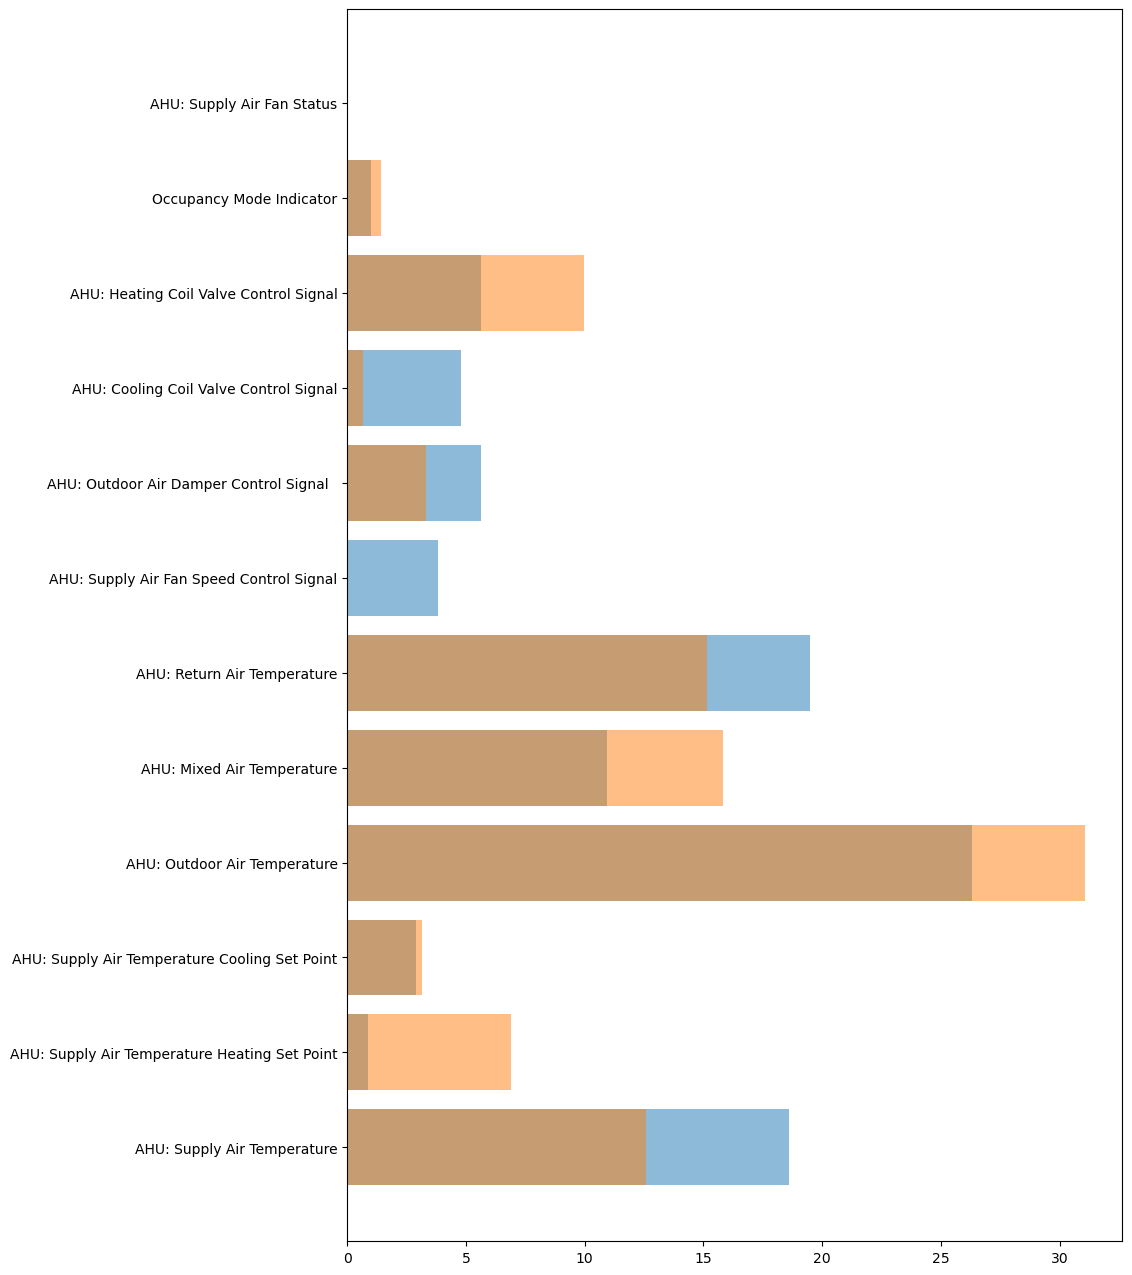

In [134]:
plt.figure(figsize=(10,16))
plt.barh(X_train_oa_vav.columns, models_oa_vav[4].get_feature_importance(), alpha=0.5)
plt.barh(X_train_oa_cav.columns, models_oa_cav[4].get_feature_importance(), alpha=0.5)

<BarContainer object of 11 artists>

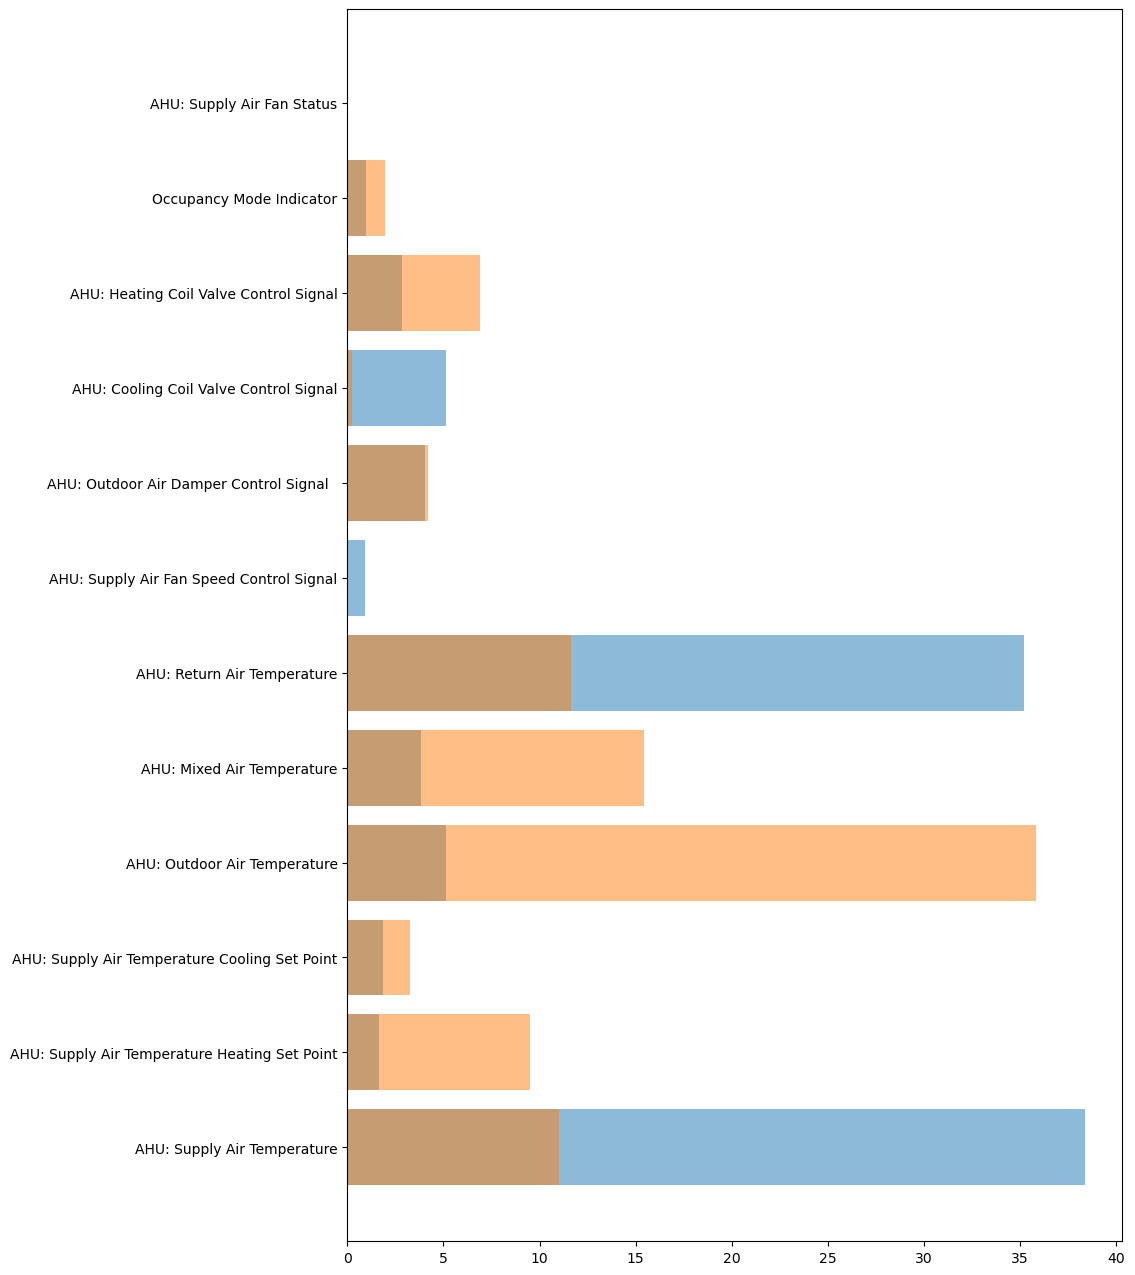

In [128]:
plt.figure(figsize=(10,16))
plt.barh(X_train_heat_vav.columns, models_heat_vav[4].get_feature_importance(), alpha=0.5)
plt.barh(X_train_heat_cav.columns, models_heat_cav[4].get_feature_importance(), alpha=0.5)

<BarContainer object of 11 artists>

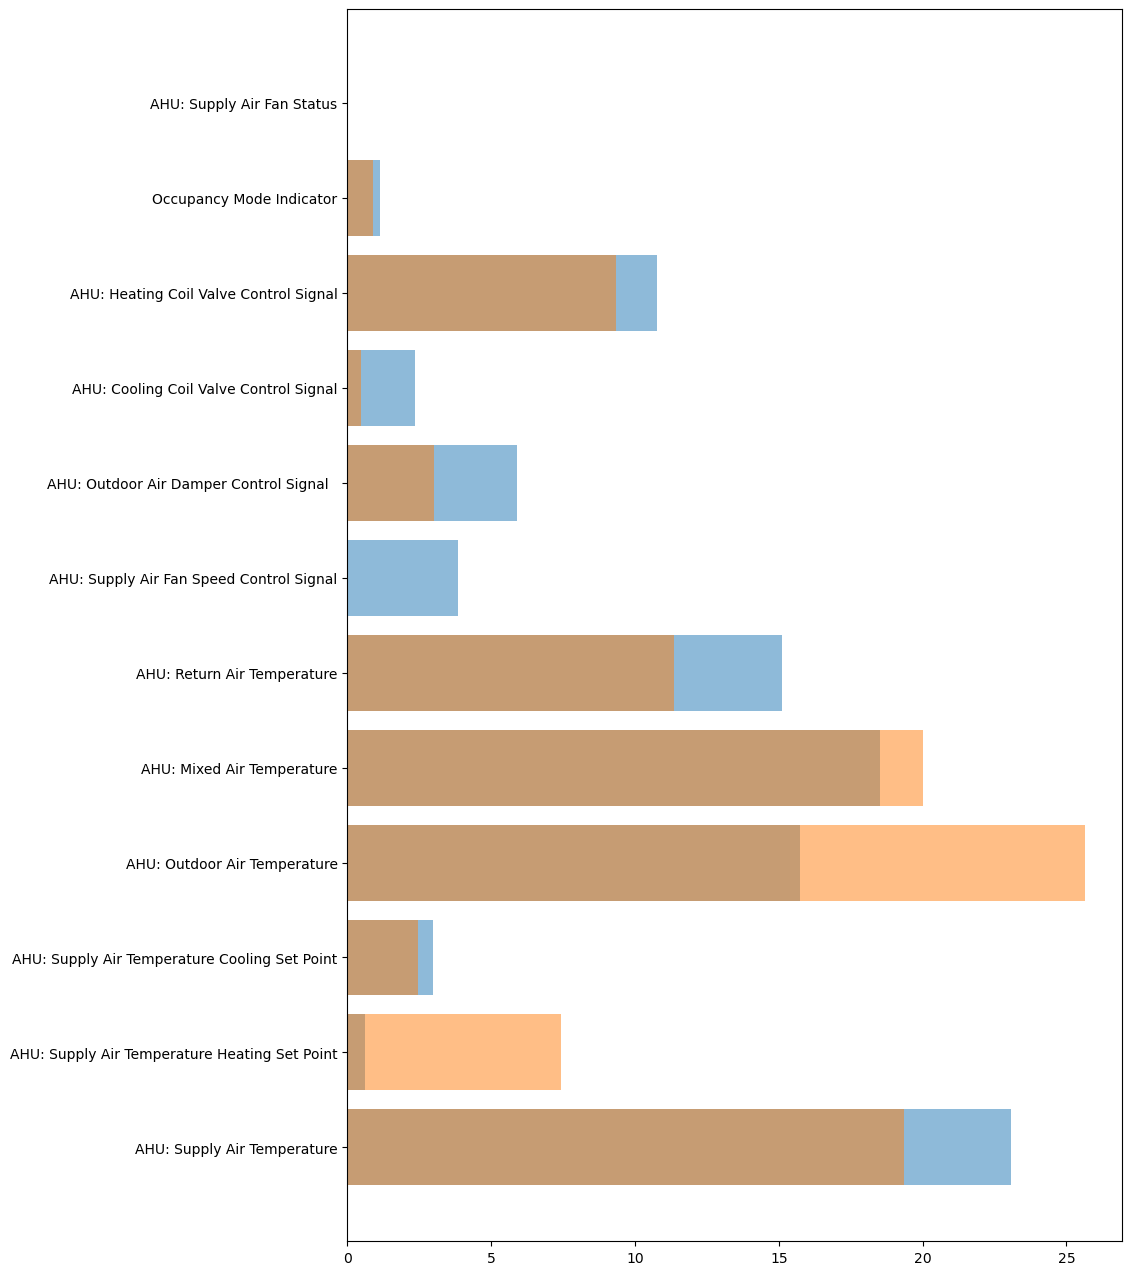

In [129]:
plt.figure(figsize=(10,16))
plt.barh(X_train_cool_vav.columns, models_cool_vav[4].get_feature_importance(), alpha=0.5)
plt.barh(X_train_cool_cav.columns, models_cool_cav[4].get_feature_importance(), alpha=0.5)

The illustrated feature importances provide valuable insights: they highlight the necessity of tailoring models to specific systems rather than relying on broad generalization. These results underscore the limitations of model applicability across different systems. The specificity of features crucial to each system accentuates the importance of system-specific modeling to ensure accurate predictions and reliable performance.

# Final toughts and conclusions

The analyzed datasets present a wealth of invaluable information concerning system behavior during failures. The majority of algorithms showcased remarkable performance in detecting faults, suggesting that the signs of failures are distinct and readily discernible to these algorithms. Upon closer scrutiny of the dataset, it might even be feasible to formulate specific fault detection conditions programmatically.

Nevertheless, leveraging machine learning algorithms offers expediency and simplicity, particularly in cases where specialized industry knowledge may be lacking. These algorithms offer rapid and effective fault detection solutions, circumventing the need for extensive domain expertise.

Developing such algorithms would ideally involve collaboration during the initial stages of building maintenance, ensuring precise fault identification or comprehensive functional tests during system commissioning. It's worth noting that these algorithms are likely to remain effective only within specific types of AHUs, possibly even specific AHU instances. However, integrating these algorithms right from the system's inception could yield substantial advantages throughout its operational lifespan.